In [278]:
%matplotlib inline
import itertools
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('bmh')
from numba import jit
from numba import njit
from time import time
# Spline interpolation
from scipy.interpolate import RectBivariateSpline
# Multiprocessing:
from concurrent.futures import ProcessPoolExecutor, as_completed

from ipywidgets import FloatProgress
from IPython.display import display

In [279]:
T0 = 4.
TMAX = 24.
factor = 10
NX = int(100*factor)
NY =  int(50*factor)

strain_res = 1e-3
fig_num = 'x2'


def grid_of_particles(N, wx=2, wy = 1.):
    # Create a grid of N (approximately) evenly spaced particles
    # covering a rectangular patch of width wx and height wy
    # centered on the point (1.0, 0.5)
    Nx = 2*int(np.sqrt(N/2))
    Ny = 1*int(np.sqrt(N/2))
    x  = np.linspace(1.0-wx/2, 1.0+wx/2, Nx)
    y  = np.linspace(0.5-wy/2, 0.5+wy/2, Ny)
    y, x = np.meshgrid(y, x)
    return np.array([x, y])


# The double gyre velocity field
@njit(parallel=True)
def doublegyre(X, t, A, e, w):
    a = e * np.sin(w*t)
    b = 1 - 2.*e*np.sin(w*t)
    f = a*X[0,:]**2 + b*X[0,:]
    v = np.empty(X.shape)
    v[0,:] = -np.pi*A*np.sin(np.pi*f) * np.cos(np.pi*X[1,:])                    # x component of velocity
    v[1,:] =  np.pi*A*np.cos(np.pi*f) * np.sin(np.pi*X[1,:]) * (2.*a*X[0,:] + b) # y component of velocity
    return v


# Wrapper function to pass to integrator
# X0 is a two-component vector [x, y]
@njit
def f(X, t):
    # Parameters of the velocity field
    A = 0.15        # A
    e = 0.3      # epsilon
    w = 2.*np.pi/10.  # omega
    return doublegyre(X, t, A, e, w)


# 4th order Runge-Kutta integrator
# X0 is a two-component vector [x, y]

def rk4(X, t, h, f):
    k1 = f(X,          t)
    k2 = f(X + k1*h/2, t + h/2)
    k3 = f(X + k2*h/2, t + h/2)
    k4 = f(X + k3*h,   t + h)
    return X + h*(k1 + 2.*k2 + 2.*k3 + k4) / 6.


# Function to calculate endpoints from
# initial positions X0 at t = 0, moving forward
# until t = tmax, using the given timestep and
# integrator

def endpoints(X0, tmax, h, integrator, f, t=0):
    # Number of timesteps
    Nt = int((tmax - t) / h)
    # Array to hold positions
    X  = np.zeros((*X0.shape,))
    # Initial position
    X[:,:] = X0
    # Loop over all timesteps
    i = 1
    while t < tmax:
        # Ensure we end up at correct time
        h = min(h, tmax - t)
        X = integrator(X, t, h, f)
        t += h
        i += 1
    # Return entire trajectory
    return X

# Step 0: Check that it works

Main grid has 500000 points
Transport took 3.621 seconds


(-0.01, 1.01)

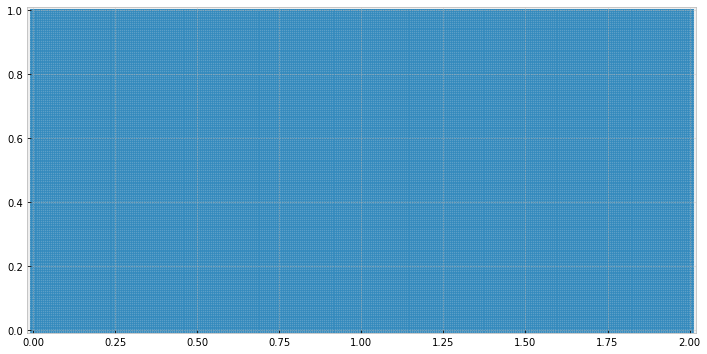

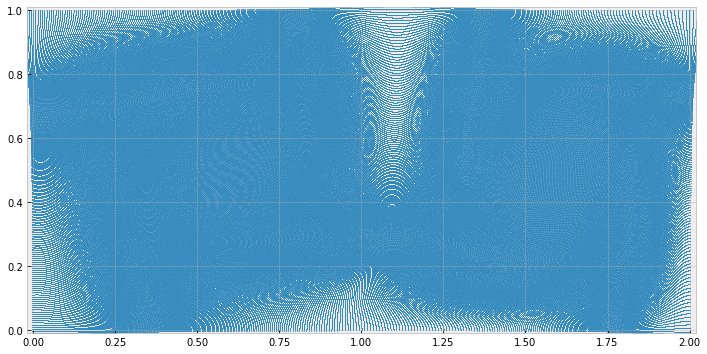

In [280]:
Np = NX*NY
X0 = grid_of_particles(Np, wx = 2.02, wy = 1.01)
print('Main grid has %s points' % X0[0,:,:].size)
# Transport parameters
tmax = 1.0
h    = 0.05

# Loop over grid and update all positions
# With timing
tic = time()
# Keep only the last position, not the entire trajectory
X1 = endpoints(X0, tmax, h, rk4, f)
toc = time()
print('Transport took %.3f seconds' % (toc - tic))

# Make scatter plot to show all grid points
fig = plt.figure(figsize = (12,6))
plt.scatter(X0[0,:], X0[1,:], lw = 0, marker = '.', s = 4)
plt.xlim(-0.02, 2.02)
plt.ylim(-0.01, 1.01)

# Make scatter plot to show all grid points
fig = plt.figure(figsize = (12,6))
plt.scatter(X1[0,:], X1[1,:], lw = 0, marker = '.', s = 4)
plt.xlim(-0.02, 2.02)
plt.ylim(-0.01, 1.01)

In [281]:
# i = 80
# j = 40

# fig = plt.figure(figsize = (18,9))
# ax = fig.add_subplot(111, aspect = 'equal')
# print(X0.shape)
# plt.scatter(X0[0,:], X0[1,:], lw = 0, marker = '.', s = 10)
# plt.scatter(X0[0,i,j], X0[1,i,j], lw = 0, marker = '.', c = 'r', s = 50)
# plt.xlim(1.0, 1.1)
# plt.ylim(0.675, 0.725)

# fig = plt.figure(figsize = (18,9))
# ax = fig.add_subplot(111, aspect = 'equal')
# plt.scatter(X1[0,:], X1[1,:], lw = 0, marker = '.', s = 10)
# plt.scatter(X1[0,i,j], X1[1,i,j], lw = 0, marker = '.', c = 'r', s = 50)
# plt.xlim(1.0, 1.1)
# plt.ylim(0.4, 0.45)

# Step 1: Identify a suitable timestep

In [282]:
# Np = 125000
# X0 = grid_of_particles(Np, wx = 2, wy = 1)
# # Transport parameters
# tmax = 17.0
# hs   = np.logspace(-2, 1, 20)
# href = 1e-1
# # Array to hold final positions for each timestep
# Xs = np.empty((*X0.shape, len(hs)))

# progressbar = FloatProgress(min = 0, max = len(hs) + 1)
# display(progressbar)

# # Calculate reference solution
# Xref = endpoints(X0, tmax, href, rk4, f)
# progressbar.value += 1
# # Loop over timesteps
# for i, h in enumerate(hs):
#     progressbar.value += 1
#     # Loop over grid and update all positions
#     # Keep only the last position, not the entire trajectory
#     tic = time()
#     Xs[:,:,:,i] = endpoints(X0, tmax, h, rk4, f)
#     toc = time()
#     print('Transport for h = %.3f s took %.3f seconds' % (h, (toc - tic)))

In [283]:
# # Calculate average error
# avgerrs = np.sqrt(np.sum((Xs - Xref.reshape((*Xref.shape, 1)))**2, axis = (0, 1, 2))) / Np
# maxerrs = np.amax(np.sqrt(np.sum((Xs - Xref.reshape((*Xref.shape, 1)))**2, axis = 0)), axis = (0,1))

# fig = plt.figure(figsize = (12, 8))
# plt.plot(hs, (avgerrs[0]/hs[0]**4)*hs**4, c = 'k', lw = 1, alpha = 0.5, label = '$\sim h^4$')
# plt.scatter(hs, avgerrs, marker = 'o', s = 40, facecolor = 'k', edgecolor = 'k', label = 'Avg error')
# plt.scatter(hs, maxerrs, marker = 'o', s = 40, facecolor = '',  edgecolor = 'k', label = 'Max error')
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(hs[0], hs[-1])
# plt.legend(loc = 'upper left', scatterpoints = 1)

# Step 2: Calculate flow map with large number of particles
## Also, calculate four auxiliary grid points per particle, as described in Eq. (6) and Fig. 5 of Farazmand and Haller (2012)

In [284]:
# Transport parameters
t0 = T0
tmax =  TMAX
h    =  0.1

# Main grid initial points
Np   = NX*NY
X0m  = grid_of_particles(Np, wx = 2.04, wy = 1.02)
Nx   = X0m.shape[1]
Ny   = X0m.shape[2]
# Grid parameters of original grid
dxm = X0m[0,1,0] - X0m[0,0,0]
dym = X0m[1,0,1] - X0m[1,0,0]

# Auxiliary grid initial points
dxa        = 1e-5
dya        = 1e-5
X0a        = np.empty((2, 2, 2, Nx, Ny))
X1a        = np.empty((2, 2, 2, Nx, Ny))
X0a[0,0,:] = X0m + np.array([-dxa, 0]).reshape(2,1,1)
X0a[1,0,:] = X0m + np.array([ dxa, 0]).reshape(2,1,1)
X0a[0,1,:] = X0m + np.array([ 0,-dya]).reshape(2,1,1)
X0a[1,1,:] = X0m + np.array([ 0, dya]).reshape(2,1,1)

print('Main grid consists of %s x %s = %s points.' % (Nx, Ny, Nx*Ny))
print('Corners: ', (X0m[0,0,0], X0m[1,0,0]), (X0m[0,-1,-1], X0m[1,-1,-1]))
print('dxm = ', dxm, 'dym = ', dym)
print('dxa = ', dxa, 'dya = ', dya)

# Progress bar
progressbar = FloatProgress(min = 0, max = 5)
display(progressbar)

# Trajectory endpoints
X1m   = endpoints(X0m, tmax, h, rk4, f, t=t0)
progressbar.value += 1
X1a[0,0,:] = endpoints(X0a[0,0,:], tmax, h, rk4, f, t=t0)
progressbar.value += 1
X1a[1,0,:] = endpoints(X0a[1,0,:], tmax, h, rk4, f, t=t0)
progressbar.value += 1
X1a[0,1,:] = endpoints(X0a[0,1,:], tmax, h, rk4, f, t=t0)
progressbar.value += 1
X1a[1,1,:] = endpoints(X0a[1,1,:], tmax, h, rk4, f, t=t0)
progressbar.value += 1

# Flow maps
FMm = X1m - X0m
FMa = X1a - X0a

# Save results to disk
np.save('../data/X0m_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0), X0m)
np.save('../data/X0a_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0), X0a)
np.save('../data/X1m_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0), X1m)
np.save('../data/X1a_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0), X1a)
np.save('../data/FMm_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0), FMm)
np.save('../data/FMa_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0), FMa)

Main grid consists of 1000 x 500 = 500000 points.
Corners:  (-0.020000000000000018, -0.010000000000000009) (2.02, 1.01)
dxm =  0.002042042042042041 dym =  0.002044088176352706
dxa =  1e-05 dya =  1e-05


A Jupyter Widget

In [285]:
Nx = NX
Ny =  NY
t0 = T0
tmax = TMAX

# Load data from disk
X0m = np.load('../data/X0m_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0))
X0a = np.load('../data/X0a_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0))
X1m = np.load('../data/X1m_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0))
X1a = np.load('../data/X1a_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0))
FMm = np.load('../data/FMm_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0))
FMa = np.load('../data/FMa_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0))
X0 = X0m
# Grid parameters of original grid
dxm = X0m[0,1,0] - X0m[0,0,0]
dym = X0m[1,0,1] - X0m[1,0,0]
# Grid parameter of auxiliary grid
dxa = X0m[0,0,0] - X0a[0,0,0,0,0]
dya = X0m[1,0,0] - X0a[0,1,1,0,0]

print('Main grid consists of %s x %s = %s points.' % (Nx, Ny, Nx*Ny))
print('Corners: ', (X0m[0,0,0], X0m[1,0,0]), (X0m[0,-1,-1], X0m[1,-1,-1]))
print('dxm = ', dxm, 'dym = ', dym)
print('dxa = ', dxa, 'dya = ', dya)

Main grid consists of 1000 x 500 = 500000 points.
Corners:  (-0.020000000000000018, -0.010000000000000009) (2.02, 1.01)
dxm =  0.002042042042042041 dym =  0.002044088176352706
dxa =  9.999999999999593e-06 dya =  9.999999999999593e-06


# Step 3: Calculate derivatives of flow maps

In [286]:
# Arrays to hold derivatives for original array and auxiliary array
dFMm = np.ones((Nx, Ny, 2, 2))
dFMa = np.ones((Nx, Ny, 2, 2))

#### Derivatives for original array ####
# dFMm_x/dx
dFMm[1:-1, :  ,0,0] = (   X1m[0,2:  , :  ] -   X1m[0, :-2, :  ] )                     / (2*dxm) # Central finite difference
dFMm[   0, :  ,0,0] = ( 4*X1m[0,   1, :  ] - 3*X1m[0,   0, :  ] - 2*X1m[0,   2, :  ]) / (2*dxm)  # One-sided finite difference
dFMm[  -1, :  ,0,0] = ( 3*X1m[0,  -1, :  ] - 4*X1m[0,  -2, :  ] + 2*X1m[0,  -3, :  ]) / (2*dxm)  # One-sided finite difference
# dFMm_x/dy
dFMm[ :  ,1:-1,0,1] = (   X1m[0, :  , 2: ] -   X1m[0, :  , :-2] )                     / (2*dym) # Central finite difference
dFMm[ :  ,   0,0,1] = ( 4*X1m[0, :  ,   1] - 3*X1m[0, :  ,   0] - 2*X1m[0, :  ,   2]) / (2*dym)  # One-sided finite difference
dFMm[ :  ,  -1,0,1] = ( 3*X1m[0, :  ,  -1] - 4*X1m[0, :  ,  -2] + 2*X1m[0, :  ,  -3]) / (2*dym)  # One-sided finite difference
# dFMm_y/dx
dFMm[1:-1, :  ,1,0] = (   X1m[1,2:  , :  ] -   X1m[1, :-2, :  ] )                     / (2*dxm) # Central finite difference
dFMm[   0, :  ,1,0] = ( 4*X1m[1,   1, :  ] - 3*X1m[1,   0, :  ] - 2*X1m[1,   2, :  ]) / (2*dxm)  # One-sided finite difference
dFMm[  -1, :  ,1,0] = ( 3*X1m[1,  -1, :  ] - 4*X1m[1,  -2, :  ] + 2*X1m[1,  -3, :  ]) / (2*dxm)  # One-sided finite difference
# dFMm_y/dy
dFMm[ :  ,1:-1,1,1] = (   X1m[1, :  , 2: ] -   X1m[1, :  , :-2] )                      / (2*dym) # Central finite difference
dFMm[ :  ,   0,1,1] = ( 4*X1m[1, :  ,   1] - 3*X1m[1, :  ,   0] - 2*X1m[1, :  ,   2] ) / (2*dym)  # One-sided finite difference
dFMm[ :  ,  -1,1,1] = ( 3*X1m[1, :  ,  -1] - 4*X1m[1, :  ,  -2] + 2*X1m[1, :  ,   -3]) / (2*dym)  # One-sided finite difference

#### Derivatives for auxiliary array ####
# dx/dx
#FMa -> X1a
dFMa[:,:,0,0] = ( X1a[0,0,0,:,:] - X1a[1,0,0,:,:] ) / (2*dxa) # Central finite difference
# dx/dy
dFMa[:,:,0,1] = ( X1a[0,1,0,:,:] - X1a[1,1,0,:,:] ) / (2*dya) # Central finite difference
# dx/dx
dFMa[:,:,1,0] = ( X1a[0,0,1,:,:] - X1a[1,0,1,:,:] ) / (2*dxa) # Central finite difference
# dx/dy
dFMa[:,:,1,1] = ( X1a[0,1,1,:,:] - X1a[1,1,1,:,:] ) / (2*dya) # Central finite difference

# Step 4: Calculate Cauchy-Green strain tensor

In [287]:
CGm = np.matmul(np.transpose(dFMm, axes = (0,1,3,2)), dFMm)
CGa = np.matmul(np.transpose(dFMa, axes = (0,1,3,2)), dFMa)

# Step 5: Calculate eigenvalues and eigenvectors of Cauchy-Green strain tensor

## Calculate eigenvalues from main grid, and eigenvectors from auxiliary grid

In [288]:
vals_m, vecs_m = np.linalg.eigh(CGm)
vals_a, vecs_a = np.linalg.eigh(CGa)
# Store values and vectors separately for less indexing hassle
lambda1 = vals_m[:,:,0]
lambda2 = vals_m[:,:,1]
xi1     = vecs_a[:,:,:,0]
xi2     = vecs_a[:,:,:,1]

In [289]:
np.amax(vals_m - vals_a)

3228858.468294452

# Step 5b: Plot largest eigenvalue and FTLE

(-0.01, 1.01)

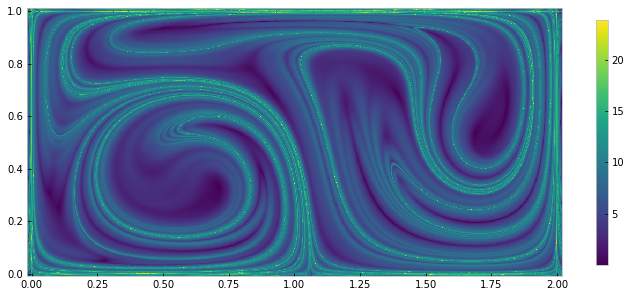

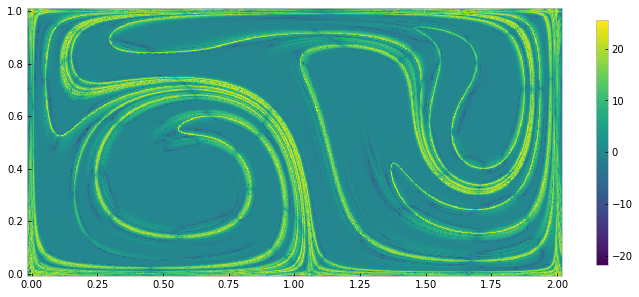

In [290]:
fig = plt.figure(figsize = (12,5))
ax = fig.add_subplot(111, aspect = 'equal')
#mesh = ax.pcolormesh(X0m[0,:,:], X0m[1,:,:], np.log(vals_a[:,:,0]*vals_a[:,:,1]))
mesh = ax.pcolormesh(X0m[0,:,:], X0m[1,:,:], np.log(vals_a[:,:,1]))
plt.colorbar(mesh, shrink = 0.9)
plt.xlim(-0.02, 2.02)
plt.ylim(-0.01, 1.01)

fig = plt.figure(figsize = (12,5))
ax = fig.add_subplot(111, aspect = 'equal')
mesh = ax.pcolormesh(X0m[0,:,:], X0m[1,:,:], np.log(vals_m[:,:,0]*vals_m[:,:,1]))
#mesh = ax.pcolormesh(X0m[0,:,:], X0m[1,:,:], np.log(vals_m[:,:,1]))
plt.colorbar(mesh, shrink = 0.9)
plt.xlim(-0.02, 2.02)
plt.ylim(-0.01, 1.01)

(-0.01, 1.01)

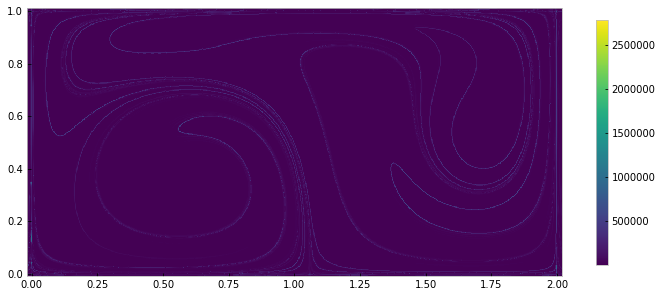

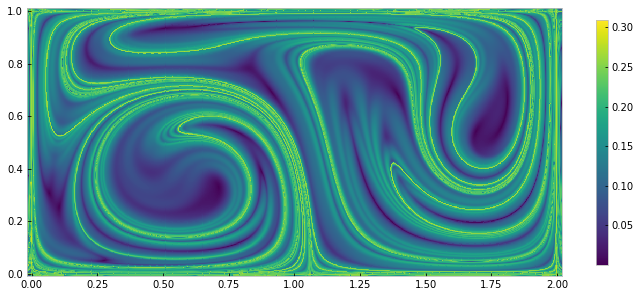

In [291]:
fig = plt.figure(figsize = (12,5))
ax = fig.add_subplot(111, aspect = 'equal')
mesh = plt.pcolormesh(X0m[0,:,:], X0m[1,:,:], lambda2)
plt.colorbar(mesh, shrink = 0.9)
plt.xlim(-0.02, 2.02)
plt.ylim(-0.01, 1.01)

fig = plt.figure(figsize = (12,5))
ax = fig.add_subplot(111, aspect = 'equal')
mesh = plt.pcolormesh(X0m[0,:,:], X0m[1,:,:], np.log(lambda2)/(2*tmax))
plt.colorbar(mesh, shrink = 0.9)
plt.xlim(-0.02, 2.02)
plt.ylim(-0.01, 1.01)

# Step 6: Identify those initial points that belong to $\mathcal{G}_0$

## i.e., those points where conditions A and B hold:

### Condition A:  $\lambda_1(\mathbf{x}_0) \neq \lambda_2(\mathbf{x}_0) > 1$
### Condition B:  $\langle \xi_2(\mathbf{x}_0), \nabla^2 \lambda_2(\mathbf{x}_0) \xi_2(\mathbf{x}_0) \rangle \leq 0$

In [292]:
Atol = 0.0
Atrue = np.logical_and(np.abs(lambda1 - lambda2) > Atol, lambda2 - 1. > Atol)
#Atrue = np.logical_and(lambda2 == lambda2, lambda2 == lambda2)
print('Number of points where A is true: ', np.sum(Atrue))



lmbd = lambda2.reshape((Nx,Ny))
    
hessian = np.zeros((Nx,Ny,2,2))
    
# First, the laplacian terms:
    
# Internal points: Centered differences
hessian[1:-1,:,0,0] = (lmbd[2:,:]-2*lmbd[1:-1,:]+lmbd[:-2,:])/(dxm**2)
hessian[:,1:-1,1,1] = (lmbd[:,2:]-2*lmbd[:,1:-1]+lmbd[:,:-2])/(dym**2)
    
    # Near boundaries: Higher order forwards/backwards differences
hessian[0,:,0,0] = (2*lmbd[0,:]-5*lmbd[1,:]+4*lmbd[2,:]-lmbd[3,:])/(dxm**2)
hessian[-1,:,0,0] = (2*lmbd[-1,:]-5*lmbd[-2,:]+4*lmbd[-3,:]-lmbd[-4,:])/(dxm**2)
    
hessian[:,0,1,1] = (2*lmbd[:,0]-5*lmbd[:,1]+4*lmbd[:,2]-lmbd[:,3])/(dym**2)
hessian[:,-1,1,1] = (2*lmbd[:,-1]-5*lmbd[:,-2]+4*lmbd[:,-3]-lmbd[:,-4])/(dym**2)

# Then, the mixed derivatives:
dldx = np.empty((Nx,Ny))
dldy = np.empty((Nx,Ny))

# Internal points: Centered differences
dldx[1:-1,:] = (lmbd[2:,:]-lmbd[:-2,:])/(2*dxm)
dldy[:,1:-1] = (lmbd[:,2:]-lmbd[:,:-2])/(2*dym)

# Near boundaries: Higher order forwards/backwards differences
dldx[0,:] = (-3*lmbd[0,:]+4*lmbd[1,:]-lmbd[2,:])/(2*dxm)
dldx[-1,:] = (3*lmbd[-1,:]-4*lmbd[-2,:]+lmbd[-3,:])/(2*dxm)

dldy[:,0] = (-3*lmbd[:,0]+4*lmbd[:,1]-lmbd[:,2])/(2*dym)
dldy[:,-1] = (3*lmbd[:,-1]-4*lmbd[:,-2]+lmbd[:,-3])/(2*dym)



# Same deal for the mixed derivatives
d2ldxdy = np.empty((Nx,Ny))
d2ldydx = np.empty((Nx,Ny))

# Internal points: Centered differences
d2ldxdy[1:-1,:] = (dldy[2:,:]-dldy[:-2,:])/(2*dxm)
d2ldydx[:,1:-1] = (dldx[:,2:]-dldx[:,:-2])/(2*dym)

# Near boundaries: Higher order forwards/backwards differences
d2ldxdy[0,:] = (-3*dldy[0,:]+4*dldy[1,:]-dldy[2,:])/(2*dxm)
d2ldxdy[-1,:] = (3*dldy[-1,:]-4*dldy[-2,:]+dldy[3,:])/(2*dxm)

d2ldydx[:,0] = (-3*dldx[:,0]+4*dldx[:,1]-dldx[:,2])/(2*dym)
d2ldydx[:,-1] = (3*dldx[:,-1]-4*dldx[:,-2]+dldx[:,-3])/(2*dym)

hessian[:,:,0,1] = d2ldxdy
hessian[:,:,1,0] = d2ldydx

hessian = hessian[:,:,:,:].reshape(((Nx)*(Ny), 2, 2))
xi2_m = xi2.reshape((Nx*Ny), 2)
# Taking inner product, although it seems useless
#inner   = np.sum(xi1 * (hessian)[:,:,0] * xi1, axis = -1)
inner = np.sum(xi2_m * np.sum(hessian*xi2_m[...,np.newaxis], axis=1), axis=1)
Btol = 0.0
inner = inner.reshape((Nx,Ny))
Btrue   = inner  <= Btol
print('Number of points where B is true: ', np.sum(Btrue))

ABtrue = np.logical_and(Atrue, Btrue)

print('Number of points where A and B is true: ', np.sum(ABtrue))

Number of points where A is true:  500000
Number of points where B is true:  134993
Number of points where A and B is true:  134993


In [293]:
# i = 250
# j = 140
# print(lambda1[i,j], lambda2[i,j])
# np.amin(lambda2)

(-0.01, 1.01)

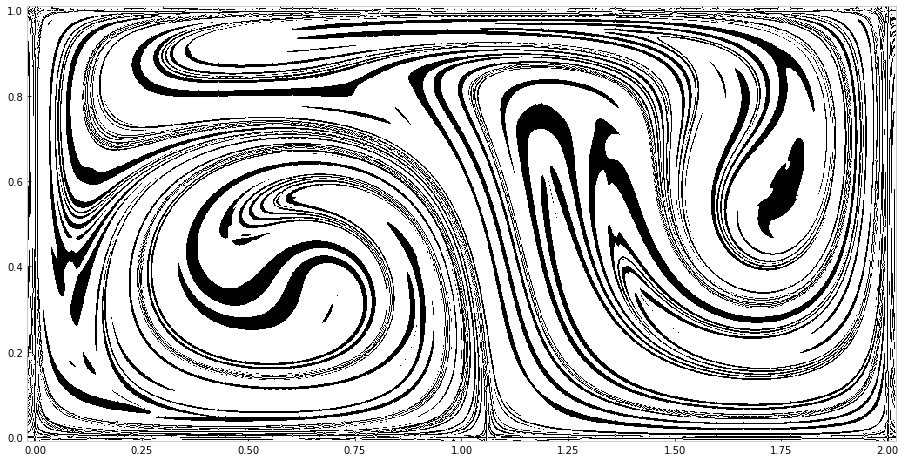

In [294]:
fig = plt.figure(figsize = (16, 8))
# ax = fig.add_subplot(111, aspect = 'equal')
# plt.pcolormesh(X0m[0,:,:], X0m[1,:,:], Atrue, cmap = plt.get_cmap('Greys'))
# plt.xlim(-0.02, 2.02)
# plt.ylim(-0.01, 1.01)

# fig = plt.figure(figsize = (16, 8))
# ax = fig.add_subplot(111, aspect = 'equal')
# plt.pcolormesh(X0m[0,:,:], X0m[1,:,:], Btrue, cmap = plt.get_cmap('Greys'))
# plt.xlim(-0.02, 2.02)
# plt.ylim(-0.01, 1.01)

fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot(111, aspect = 'equal')
plt.pcolormesh(X0m[0,:,:], X0m[1,:,:], ABtrue, cmap = plt.get_cmap('Greys'))
plt.xlim(-0.02, 2.02)
plt.ylim(-0.01, 1.01)
#plt.savefig('AB1.png', dpi = 300)

# plt.figure(figsize = (16,10), dpi = 200)
# plt.scatter(X0m[0,ABtrue], X0m[1,ABtrue], lw = 0, marker = '.', s = 5, color = 'k')


# Step 7: Choose those points that lie on four horizontal and vertical lines 

In [295]:
mask = np.zeros((Nx, Ny), dtype = np.bool)
for i in range(1,5):
    mask[:,min( int(i*Ny/5), Ny-1)] = True
    mask[min( int(i*Nx/5), Nx-1),:] = True

Gx = X0m[0,:,:][np.logical_and(mask, ABtrue)]
Gy = X0m[1,:,:][np.logical_and(mask, ABtrue)]

G = np.array([Gx, Gy])

print('G has %s points' % G.shape[1])

G has 1720 points


(-0.01, 1.01)

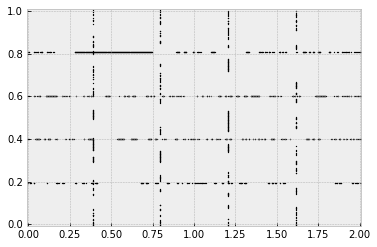

In [296]:
plt.scatter(G[0,:], G[1,:], marker = '.', c = 'k', lw = 0, s = 7)
plt.xlim(-0.01, 2.01)
plt.ylim(-0.01, 1.01)

# Step 8 - Integrate trajectories starting at the points in $\mathcal{G}$, using the eigenvector field corresponding to $\lambda_1$

## Attempt no. 2: Special-purpose linear interpolation

In [297]:
class LinearSpecial():
    def __init__(self, xc, yc, xi):
        self.xc = xc
        self.yc = yc
        self.dx = xc[1] - xc[0]
        self.dy = yc[1] - yc[0]
        self.xi = xi
        self.Nx = len(xc)
        self.Ny = len(yc)
        self.fold = None
        
    def __call__(self, X, t):
        # Calculate indices for lower left corner in cell
        i = np.floor((X[0] - self.xc[0]) / self.dx).astype(np.int32)
        j = np.floor((X[1] - self.yc[0]) / self.dy).astype(np.int32)
        
        # If outside the domain, stop
        if (i >= Nx - 2) or (j >= Ny - 2) or (i < 0) or (j < 0):
            raise IndexError
        
        # Use the lower left corner as reference, calculate
        # the rotation of the other vectors, and rotate by 180
        # degrees if required (due to orientational discontinuity)
        subxi = self.xi[:,i:i+2, j:j+2].copy()
        dotp = np.sum(subxi[:,0,0].reshape(2,1,1) * subxi, axis = 0)
        subxi[:, dotp < 0] =  -subxi[:, dotp < 0]
        
        # Linear interpolation
        Wx0 = (self.xc[i+1] - X[0]) / self.dx
        Wx1 = 1 - Wx0
        Wy0 = (self.yc[j+1] - X[1]) / self.dy
        Wy1 = 1 - Wy0

        V = Wy0*(Wx0*subxi[:,0,0] + Wx1*subxi[:,1,0]) + Wy1*(Wx0*subxi[:,0,1] + Wx1*subxi[:,1,1])
                
        # Check orientation against previous vector
        if self.fold is None:
            return V
        else:
            # If dot product is negative, flip direction
            return V * np.sign(np.dot(V, self.fold))
            
def half_strainline(x0, Tmax, h, f, xc, yc, lambda2, ABtrue, pm, max_notAB = 0.3, t=0):
    # Re-initialise the f-function
    f.fold = None

    Nt = int((Tmax-t) / h)
    xs = np.zeros((2, Nt))
    xs[:,0] = x0
    dx = xc[1] - xc[0]
    dy = yc[1] - yc[0]
    
    # Buffer zone outside domain
    xbuf = 0.01
    ybuf = 0.005
    
    # Parameters of strainline
    length = 0.0
    notABlength = 0.0
    mulambda = 0.0

    for n in range(1, Nt):
        f.fold = f(xs[:,n-1], t)
        try:
            xs[:,n] = rk4(xs[:,n-1], t, pm*h, f)
        except IndexError:
            break
        if xs[0,n] < (0.0-xbuf) or (2.0+xbuf) < xs[0,n] or xs[1,n] < (0.0-ybuf) or (1.0+ybuf) < xs[1,n]:
            break
        if notABlength > max_notAB:
            break

        # increment length
        dl = np.sqrt(np.sum((xs[:,n] - xs[:,n-1])**2))
        length += dl
        # calculate closest grid point
        i = np.floor(((xs[0,n]+dx/2) - xc[0]) / dx).astype(np.int32)
        j = np.floor(((xs[1,n]+dy/2) - yc[0]) / dy).astype(np.int32)
        # Use this to look up lambda2, and add to running total
        mulambda += lambda2[i,j] * dl
        # Check if A and B are satisfied
        if ABtrue[i, j]:
            notABlength = 0
        else:
            notABlength += dl

    if length > 0:
        mulambda = mulambda / length
    else:
        mulambda = 0.0
    return xs[:,:n], length, mulambda

def strainline(x0, Tmax, h, f, xc, yc, lambda2, ABtrue, max_notAB = 0.3, t=0):
    line1, length1, mulambda1 = half_strainline(x0, Tmax, h, f, xc, yc, lambda2, ABtrue, pm = +1, max_notAB = max_notAB, t=t)
    line2, length2, mulambda2 = half_strainline(x0, Tmax, h, f, xc, yc, lambda2, ABtrue, pm = -1, max_notAB = max_notAB, t=t)
    length = length1 + length2
    if length > 0:
        mulambda = (length1*mulambda1 + length2*mulambda2) / length
    else:
        mulambda = 0.0
    N1  = line1.shape[1]
    N2  = line2.shape[1]
    line = np.zeros((2, N1+N2-1))
    line[:,:N1] = line1[:,::-1]
    line[:,N1:] = line2[:,1:]
    return line, length, mulambda

In [298]:
# 1D-arrays of grid coordinates for convenience
xc = X0m[0,:,0]
yc = X0m[1,0,:]

# Create interpolator object, with the eigenvector field
# corresponding to the smallest eigenvalues

EigVec = np.zeros((2, 2, xi1.shape[0], xi1.shape[1]))
EigVec[:, 0, :, :] = np.rollaxis(xi1, 2, 0)
EigVec[:, 1, :, :] = np.rollaxis(xi2, 2, 0)

print(lambda2.shape)
EigVal = np.zeros((2, lambda2.shape[0], lambda2.shape[1]))
EigVal[0, :, :] = lambda1
EigVal[1, :, :] = lambda2

f_xi = LinearSpecial(xc, yc, EigVec[:,0,:,:])

# List to hold strainlines and associated parameters
# (number not known ahead of time, hence lists)
strainlines   = []
lengths       = []
lengths_notAB = []
eigvals_mean  = []

# Filtering parameters
max_notAB  = 0.2
min_length = 1.0
# Trajectory integration parameters
# Note: "Speed" is 1 everywhere, since eigenvectors
# are normalised. Thus Tmax gives max length directly
Tmax = 1*(TMAX )
h    = strain_res

progressbar = FloatProgress(min=0, max=G.shape[1])
display(progressbar)

futures = []
with ProcessPoolExecutor(8) as executor:
    for i in range(G.shape[1]):
        progressbar.value += 1
        futures.append(executor.submit(strainline, G[:,i], Tmax, h, f_xi, xc, yc, EigVal[1,:,:], ABtrue, max_notAB = max_notAB, t=t0))
    

progressbar = FloatProgress(min=0, max=G.shape[1])
display(progressbar)
for p in as_completed(futures):
    progressbar.value += 1
    try:
        line, length, eigval_mean = p.result()
        if length > min_length:
            strainlines.append(line)
            lengths.append(length)
            eigvals_mean.append(eigval_mean)
    except IndexError:
        pass

print('Identified %s LCS candidates' % len(strainlines))

(1000, 500)


A Jupyter Widget

A Jupyter Widget

Identified 1598 LCS candidates


In [299]:
# 1D-arrays of grid coordinates for convenience
xc = X0m[0,:,0]
yc = X0m[1,0,:]
dx = xc[1] - xc[0]
dy = yc[1] - yc[0]

inside_eigvals  = []
running_eigvals = []
running_ABtrues = []

progressbar = FloatProgress(min=0, max=len(strainlines))
display(progressbar)

for i in range(len(strainlines)):
    progressbar.value += 1
    eigvals = np.zeros(strainlines[i].shape[1])
    ABtrues = np.zeros(strainlines[i].shape[1], dtype = np.bool)
    for n in range(strainlines[i].shape[1]):
        igrid = np.floor(((strainlines[i][0,n]+dx/2) - xc[0]) / dx).astype(np.int32)
        jgrid = np.floor(((strainlines[i][1,n]+dy/2) - yc[0]) / dy).astype(np.int32)
        if ABtrue[igrid, jgrid]:
            ABtrues[n] = True
            eigvals[n] = EigVal[1,igrid,jgrid]
    inside_eigvals.append(np.sum(eigvals[ABtrues]) / np.sum(ABtrues))
    running_eigvals.append(eigvals)
    running_ABtrues.append(ABtrues)

A Jupyter Widget

In [300]:
# fig = plt.figure(figsize = (12, 6))

# #plt.pcolormesh(X0m[0,:,:], X0m[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.15)
# mesh = plt.pcolormesh(X0m[0,:,:], X0m[1,:,:], np.log(EigVal[1,:,:]), cmap = plt.get_cmap('Greys_r'))

# cmap = plt.get_cmap('viridis')
# maxeigval = np.amax(eigvals_mean)
# for i in range(len(strainlines)):
#     if lengths[i] > 2:
#         colors = [cmap(eigval / maxeigval)[:3] for eigval in running_eigvals[i]]
#         plt.scatter(strainlines[i][0,:], strainlines[i][1,:], marker = '.', s = 1, edgecolor = '', color = colors, lw = 1 )

# plt.xlim(-0.1, 2.1)
# plt.ylim(-0.1, 1.1)

# plt.tight_layout()
# #plt.savefig('strainlines_eigenvalues.png', dpi = 300)

In [301]:
# fig = plt.figure(figsize = (12, 6))

# #plt.pcolormesh(X0m[0,:,:], X0m[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.15)
# mesh = plt.pcolormesh(X0m[0,:,:], X0m[1,:,:], np.log(EigVal[1,:,:]), cmap = plt.get_cmap('Greys_r'))

# cmap = plt.get_cmap('viridis')
# maxeigval = np.amax(eigvals_mean)
# for i in range(len(strainlines)):
#     if lengths[i] > 1 and (inside_eigvals[i] / maxeigval) > 0.0:
#         plt.plot(strainlines[i][0,:], strainlines[i][1,:], c = cmap(eigvals_mean[i] / maxeigval), lw = 1 )

# plt.xlim(-0.1, 2.1)
# plt.ylim(-0.1, 1.1)

# plt.tight_layout()
# #plt.savefig('strainlines_average_eigenvalues.png', dpi = 300)

In [302]:
# fig = plt.figure(figsize = (12, 6))

# #plt.pcolormesh(X0m[0,:,:], X0m[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.15)
# mesh = plt.pcolormesh(X0m[0,:,:], X0m[1,:,:], np.log(EigVal[1,:,:]), cmap = plt.get_cmap('Greys_r'))

# cmap = plt.get_cmap('viridis')
# maxeigval = np.amax(inside_eigvals)
# for i in range(len(strainlines)):
#     if lengths[i] > 2 and (inside_eigvals[i] / maxeigval) > 0.25:
#         colors = [cmap(eigval / maxeigval) for eigval in running_eigvals[i]]
#         plt.scatter(strainlines[i][0,:], strainlines[i][1,:], marker = '.', edgecolor = '', color = colors, lw = 1 )


# plt.xlim(1.50, 1.90)
# plt.ylim(0.80, 1.00)

# plt.tight_layout()
# #plt.savefig('attempt2.png')

(2, 1000, 500)


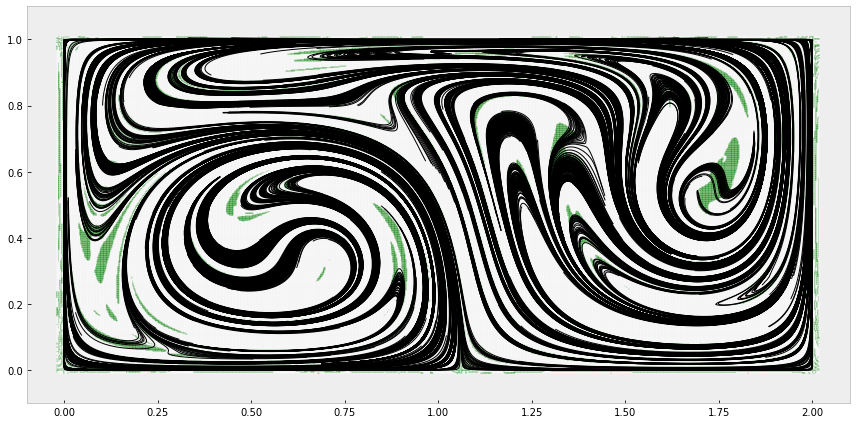

In [303]:
print(X0.shape)
fig = plt.figure(figsize = (12, 6))

plt.pcolormesh(X0[0,:,:], X0[1,:,:], np.logical_and(Atrue, Btrue), cmap = plt.get_cmap('ocean_r'), alpha = 0.15)

fLCSs = strainlines
flengths = lengths
for i in range(len(fLCSs)):
        plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 1 )

plt.xlim(-0.1, 2.1)
plt.ylim(-0.1, 1.1)

plt.tight_layout()
# #plt.savefig('attempt2.png')

In [304]:


def get_values_x(x0, y0, x1, y1, flambda2, xline):
    w0 = (x1 - xline) / (x1 - x0)
    w1 = 1 - w0
    x = xline
    y = w0*y0 + w1*y1
    return x, y, flambda2(x, y, grid = False)


def get_values_y(x0, y0, x1, y1, flambda2, yline):
    w0 = (y1 - yline) / (y1 - y0)
    w1 = 1 - w0
    x = w0*x0 + w1*x1
    y = yline
    return x, y, flambda2(x, y, grid = False)


def intersect(LCSs, flambda2, xline = None, yline = None):
    assert (xline is None) or (yline is None)
    assert (xline is not None) or (yline is not None)
    
    intersect_x = []
    intersect_y = []
    intersect_l2 = []
    intersect_id = []

    for i in range(0, len(LCSs)):
        for n in range(1, LCSs[i].shape[1]):
            if xline is not None:
                if LCSs[i][0,n-1] <= xline and xline < LCSs[i][0,n]:
                    x0, y0 = LCSs[i][:,n-1]
                    x1, y1 = LCSs[i][:,n]
                    # intersection identified, get values at intersection point
                    x, y, l2 = get_values_x(x0, y0, x1, y1, flambda2, xline)
                    intersect_x.append(x)
                    intersect_y.append(y)
                    intersect_l2.append(l2)
                    intersect_id.append(i)

                if LCSs[i][0,n] <= xline and xline < LCSs[i][0,n-1]:
                    x0, y0 = LCSs[i][:,n]
                    x1, y1 = LCSs[i][:,n-1]
                    # intersection identified, interpolate to intersection point
                    x, y, l2 = get_values_x(x0, y0, x1, y1, flambda2, xline)
                    intersect_x.append(x)
                    intersect_y.append(y)
                    intersect_l2.append(l2)
                    intersect_id.append(i)

            if yline is not None:
                if LCSs[i][1,n-1] <= yline and yline < LCSs[i][1,n]:
                    x0, y0 = LCSs[i][:,n-1]
                    x1, y1 = LCSs[i][:,n]
                    # intersection identified, interpolate to intersection point
                    x, y, l2 = get_values_y(x0, y0, x1, y1, flambda2, yline)
                    intersect_x.append(x)
                    intersect_y.append(y)
                    intersect_l2.append(l2)
                    intersect_id.append(i)

                if LCSs[i][1,n] <= yline and yline < LCSs[i][1,n-1]:
                    x0, y0 = LCSs[i][:,n]
                    x1, y1 = LCSs[i][:,n-1]
                    # intersection identified, interpolate to intersection point
                    x, y, l2 = get_values_y(x0, y0, x1, y1, flambda2, yline)
                    intersect_x.append(x)
                    intersect_y.append(y)
                    intersect_l2.append(l2)
                    intersect_id.append(i)
                    
    intersect_x  = np.array(intersect_x)
    intersect_y  = np.array(intersect_y)
    intersect_l2 = np.array(intersect_l2)
    intersect_id = np.array(intersect_id)

    if xline is not None:
        isorted = np.argsort(intersect_y)
    if yline is not None:
        isorted = np.argsort(intersect_x)

    intersect_x  = intersect_x[isorted]
    intersect_y  = intersect_y[isorted]
    intersect_l2 = intersect_l2[isorted]
    intersect_id = intersect_id[isorted]

    return intersect_x, intersect_y, intersect_l2, intersect_id


def interpolate(x0, x1, f0, f1, x):
    w0 = (x1 - x) / (x1 - x0)
    w1 = 1 - w0
    f = w0*f0 + w1*f1
    return x, f


def intersect_mu(LCSs, fmulambdas, xline = None, yline = None):
    assert (xline is None) or (yline is None)
    assert (xline is not None) or (yline is not None)
    
    intersect_x = []
    intersect_y = []
    intersect_l2 = []
    intersect_id = []

    for i in range(0, len(LCSs)):
        for n in range(1, LCSs[i].shape[1]):
            if xline is not None:
                if LCSs[i][0,n-1] <= xline and xline < LCSs[i][0,n]:
                    x0, y0 = LCSs[i][:,n-1]
                    x1, y1 = LCSs[i][:,n]
                    # intersection identified, interpolate to intersection point
                    x, y = interpolate(x0, x1, y0, y1, xline)
                    intersect_x.append(x)
                    intersect_y.append(y)
                    intersect_l2.append(fmulambdas[i])
                    intersect_id.append(i)

                if LCSs[i][0,n] <= xline and xline < LCSs[i][0,n-1]:
                    x0, y0 = LCSs[i][:,n]
                    x1, y1 = LCSs[i][:,n-1]
                    # intersection identified, interpolate to intersection point
                    x, y = interpolate(x0, x1, y0, y1, xline)
                    intersect_x.append(x)
                    intersect_y.append(y)
                    intersect_l2.append(fmulambdas[i])
                    intersect_id.append(i)

            if yline is not None:
                if LCSs[i][1,n-1] <= yline and yline < LCSs[i][1,n]:
                    x0, y0 = LCSs[i][:,n-1]
                    x1, y1 = LCSs[i][:,n]
                    # intersection identified, interpolate to intersection point
                    x, y = interpolate(y0, y1, x0, x1, yline)
                    intersect_x.append(x)
                    intersect_y.append(y)
                    intersect_l2.append(fmulambdas[i])
                    intersect_id.append(i)

                if LCSs[i][1,n] <= yline and yline < LCSs[i][1,n-1]:
                    x0, y0 = LCSs[i][:,n]
                    x1, y1 = LCSs[i][:,n-1]
                    # intersection identified, interpolate to intersection point
                    x, y = interpolate(y0, y1, x0, x1, yline)
                    intersect_x.append(x)
                    intersect_y.append(y)
                    intersect_l2.append(fmulambdas[i])
                    intersect_id.append(i)
                    
    intersect_x  = np.array(intersect_x)
    intersect_y  = np.array(intersect_y)
    intersect_l2 = np.array(intersect_l2)
    intersect_id = np.array(intersect_id)

    if xline is not None:
        isorted = np.argsort(intersect_y)
    if yline is not None:
        isorted = np.argsort(intersect_x)

    intersect_x  = intersect_x[isorted]
    intersect_y  = intersect_y[isorted]
    intersect_l2 = intersect_l2[isorted]
    intersect_id = intersect_id[isorted]

    return intersect_x, intersect_y, intersect_l2, intersect_id


def get_maxima(xs, l2s, ids, r):
    maxima = []
    for i, x in enumerate(xs):
        mask = np.abs(xs - x) < r
        if not np.amax(l2s[mask]) > l2s[i]:
            maxima.append(ids[i])
    return maxima

In [305]:
# xlines = np.linspace(0.1, 1.9, 6)
# ylines = np.linspace(0.1, 0.9, 6)

# # max distance for checking local maxima
# r = 0.2

# progressbar = FloatProgress(min=0, max = len(xlines) + len(ylines))
# display(progressbar)

# maxima = []
# for xline in xlines:
#     progressbar.value += 1
#     xs, ys, l2s, ids = intersect_mu(strainlines, eigvals_mean, xline = xline)
#     maxima += get_maxima(ys, l2s, ids, r)

# for yline in ylines:
#     progressbar.value += 1
#     xs, ys, l2s, ids = intersect_mu(strainlines, eigvals_mean, yline = yline)
#     maxima += get_maxima(xs, l2s, ids, r)

# print(len(set(maxima)))

In [306]:
xlines = np.linspace(0.1, 1.9, 4)
ylines = np.linspace(0.1, 0.9, 4)

# max distance for checking local maxima
r = 0.2

# spline interpolation of lambda2
print(X0.shape)
print(EigVal.shape)
flambda2 = RectBivariateSpline(X0[0,:,0], X0[1,0,:], EigVal[1,:,:])

progressbar = FloatProgress(min=0, max = len(xlines) + len(ylines))
display(progressbar)

maxima = []
for xline in xlines:
    progressbar.value += 1
    xs, ys, l2s, ids = intersect(fLCSs, flambda2, xline = xline)
    maxima += get_maxima(ys, l2s, ids, r)
    
maximay = maxima

for yline in ylines:
    progressbar.value += 1
    xs, ys, l2s, ids = intersect(fLCSs, flambda2, yline = yline)
    maxima += get_maxima(xs, l2s, ids, r)

print(len(set(maxima)))
print(maxima)

(2, 1000, 500)
(2, 1000, 500)


A Jupyter Widget

27
[1536, 224, 384, 1536, 1552, 1518, 556, 1015, 777, 1214, 116, 1422, 753, 1126, 273, 841, 1090, 864, 1397, 614, 1552, 566, 569, 1003, 384, 789, 1019, 1262, 224, 587, 1518, 11]


In [307]:
# fig = plt.figure(figsize = (12, 6))

# plt.pcolormesh(X0m[0,:,:], X0m[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.15)

# for i in set(maxima):
# #for i in range(len(fLCSs)):
#     plt.plot(strainlines[i][0,:], strainlines[i][1,:], c = 'k', lw = 1 )
        
# for xline in xlines:
#     plt.plot([xline, xline], [0, 1], c = '#888888', lw = 1)

# for yline in ylines:
#     plt.plot([0, 2], [yline, yline], c = '#888888', lw = 1)

# plt.xlim(-0.02, 2.02)
# plt.ylim(-0.01, 1.01)

# plt.tight_layout()
# #print(strainlines[159])

In [308]:

# fig = plt.figure(figsize = (12, 6.5))
# plt.pcolormesh(X0[0,:,:], X0[1,:,:], np.logical_and(Atrue, Btrue), cmap = plt.get_cmap('ocean_r'), alpha = 0.15)

# plt.xlim(-0.02, 2.02)
# plt.ylim(-0.01, 1.01)


# # for i in range(len(fLCSs)):
# #     l, = plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 1 )
# #     t  = plt.title(r'$L = %s, \bar{\lambda_2} = %s$' % (flengths[i], float(eigvals_mean[i])))
# #     #plt.savefig('fstrainline_%04i.png' % i)
# #     plt.tight_layout()
# #     l.remove()
# # #    t.remove()

In [309]:
# fig = plt.figure(figsize = (12, 6))

# plt.pcolormesh(X0[0,:,:], X0[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.15)

# for i in [30, 159]:
#     plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 1 )
       
# for xline in xlines:
#     plt.plot([xline, xline], [0, 1], c = '#888888', lw = 1)

# for yline in ylines:
#     plt.plot([0, 2], [yline, yline], c = '#888888', lw = 1)

# plt.xlim(-0.02, 2.02)
# plt.ylim(-0.01, 1.01)

# plt.tight_layout()
# fLCSs[71][:,:].shape 

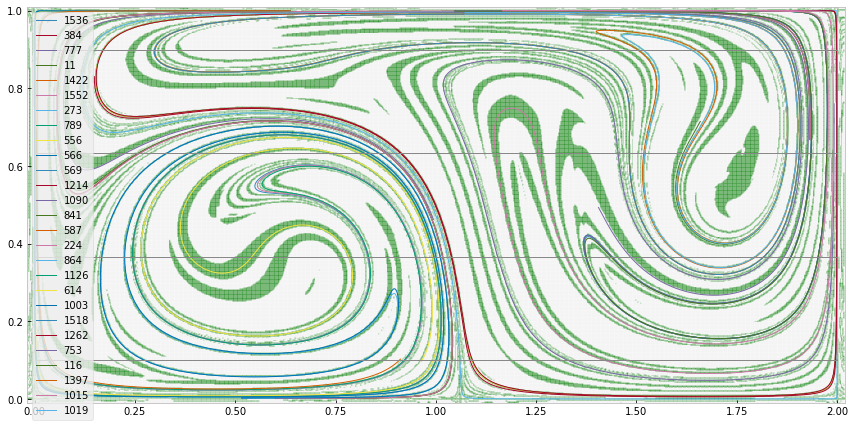

In [310]:
fig = plt.figure(figsize = (12, 6))

plt.pcolormesh(X0[0,:,:], X0[1,:,:], np.logical_and(Atrue, Btrue), cmap = plt.get_cmap('ocean_r'), alpha = 0.15)

for i in set(maximay):
    if lengths[i] >= 1.0:
        plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], lw = 1 , label = i)
        
for yline in ylines:
    plt.plot([0, 2], [yline, yline], c = '#888888', lw = 1)

plt.xlim(-0.02, 2.02)
plt.ylim(-0.01, 1.01)
plt.legend()
plt.tight_layout()
plt.savefig('test_1' + fig_num + '.png', dpi=300)


In [311]:
def find_lines(LCSs, flambda2, xlines=None, ylines=None, epsilon = 0.2):
    all_lines = []
    all_lambdas = []
    intersection_ = []
    input_lines = []
    
    x_dim = 2.
    y_dim = 1.
    
    if xlines is None and ylines is None:
        error('Need xlines or ylines')
    if xlines is None:
        input_lines = ylines
    else:
        input_lines = xlines
    for j in range(len(input_lines)):
        
        if xlines is None: 
            intersection_x, intersection_y, intersection_lambda2, intersection_id = intersect(fLCSs, flambda2, yline=ylines[j])
            intersection_ = intersection_x
        else:
            intersection_x, intersection_y, intersection_lambda2, intersection_id = intersect(fLCSs, flambda2, xline=xlines[j])
            intersection_ = intersection_y

        _lines_ = []
        _lambdas_ = []
        _iter = 0

        count = len(intersection_x)
        lambda_max = np.max(intersection_lambda2)
        while _iter < count:
            if intersection_lambda2[_iter] > 0.5 * lambda_max:

                _lines_.append(intersection_[_iter])
                _lambdas_.append(intersection_lambda2[_iter])

            _iter += 1
        all_lines.append(_lines_)
        all_lambdas.append(_lambdas_)

 
    _lines_ = []
    _lambdas_ = []

    count = 0
    while True:
        if all_lines[0][count] > 0:
            _lines_.append(all_lines[0][count])
            _lambdas_.append(all_lambdas[0][count])
            break
        count += 1
        if count == len(all_lines[0]) : break

    for i in range(0, len(all_lines)):
        for k in range(len(all_lines[i])):
            flag = 1
            for j in range(len(_lines_)):
                if np.abs(all_lines[i][k] - _lines_[j]) < epsilon:
                    flag = 0
                    if np.abs(all_lines[i][k] - _lines_[j]) < epsilon / 20 and all_lines[i][k] > 0:
                            if _lambdas_[j] < all_lambdas[i][k] and all_lambdas[i][k] not in _lambdas_:
                                _lines_[j] = all_lines[i][k]
                                _lambdas_[j] = all_lambdas[i][k]
            if flag == 1:
                if all_lines[i][k] > 0.: 

                    _lines_.append(all_lines[i][k])
                    _lambdas_.append(all_lambdas[i][k])
                    
    return _lines_, intersection_lambda2

In [312]:
# xlines_1, intersection_lambda2 = find_lines(fLCSs, flambda2, xlines=None, ylines=ylines)
# for i in range(4):
#     ylines_1, intersection_lambda2 = find_lines(fLCSs, flambda2, xlines=xlines_1, ylines=None)
#     xlines_1, intersection_lambda2 = find_lines(fLCSs, flambda2, xlines=None, ylines=ylines_1)

# xlines_1 = sorted(xlines_1)
# ylines_1 = sorted(ylines_1)
# print((xlines_1))
# print(ylines_1)

In [313]:
# #
def findLCSs(fLCSs, fmulambda, ylines, xlines, r_local):
    #list of viable LCS
    LCS = []
    n_lines = len(ylines)
    for j in range(n_lines):
        intersection_x, intersection_y, intersection_lambda2, intersection_id = intersect(fLCSs, flambda2, yline=ylines[j])

        maxIter = intersection_x.shape[0]
        
        local_lambdas = []
        local_ids = []
        
        counter = 0
        l_ind = 0
        local_max = 0
        for line in set(xlines):
            
            for i in range(maxIter):
                if np.abs(intersection_x[i] - line) < r_local:
                    local_lambdas.append(fmulambda[intersection_id[i]])
                    local_ids.append(intersection_id[i])
            if local_lambdas is not None and local_lambdas:
                l_ind = local_lambdas.index(max(local_lambdas))
                if local_ids[l_ind] not in LCS: 
                    LCS.append(local_ids[l_ind])
            local_lambdas = []
            local_ids = []
            
    n_lines = len(xlines)
    for j in range(n_lines):
        intersection_x, intersection_y, intersection_lambda2, intersection_id = intersect(fLCSs, flambda2, xline=xlines[j])

        maxIter = intersection_y.shape[0]
        
        local_lambdas = []
        local_ids = []
        
        counter = 0
        l_ind = 0
        local_max = 0
        for line in set(ylines):
            
            for i in range(maxIter):
                if np.abs(intersection_y[i] - line) < r_local:
                    local_lambdas.append(fmulambda[intersection_id[i]])
                    local_ids.append(intersection_id[i])
            if local_lambdas is not None and local_lambdas:
                l_ind = local_lambdas.index(max(local_lambdas))
                if local_ids[l_ind] not in LCS: 
                    LCS.append(local_ids[l_ind])
            local_lambdas = []
            local_ids = []

        
                
                        
   
    
    return LCS
#     #intersection_x, intersection_y, intersection_lambda2, intersection_id = intersect(fLCSs, flambda2, xline=xlines[j])

In [314]:

# xlines_1 = [0.15, 1.05, 1.95]
# ylines_1 = [0.05, 0.95]
# ret = findLCSs(fLCSs, eigvals_mean, ylines_1, xlines_1, r)
# print(ret)
# fig = plt.figure(figsize = (18, 9))

# plt.pcolormesh(X0[0,:,:], X0[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.25)

# for i in ret:
#     plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 1 )

In [315]:
def prepData(fLCSs, lines, h, r, eigvals=None):
    #n attributes
    num_dims = 2
    len_and_eigen = 0 + (eigvals is not None)

    n_samples = int(len(fLCSs) / 1)

    tot_size = 0
    max_loc_size = 0
    for i in range(n_samples):
        tot_size += len(fLCSs[i][0,:])
        if len(fLCSs[i][0,:]) > max_loc_size:
            max_loc_size = len(fLCSs[i][0,:])
            
    X = np.zeros((tot_size, num_dims + len_and_eigen + 0))
    counter = 0
    
    #array to store starting point of each line.
    flat_array_indices = np.zeros((n_samples,2))

    for i in range(n_samples):
        loc_size = len(fLCSs[i][0,:])
        for j in range(loc_size):
            X[j + counter, 0] = fLCSs[i][0,j]
            X[j + counter, 1] = fLCSs[i][1,j]
            if(eigvals is not None): X[j + counter, 2] = eigvals[i][j]
            #X[counter, 2] = eigvals_mean[i]
            #EIGEN_VALS[j+ counter] = eigvals_mean[i]
        flat_array_indices[i,0] = counter
        flat_array_indices[i,1] = lines[i]
        counter += loc_size
    progressbar = FloatProgress(min = 0, max = 3)
    display(progressbar)
    print('X total samples: %d \n' % tot_size)

    h_m = h #1e-2
    r_m = r / 15 #0.2

    #dont want to only look at points on same line ->
    #thin out so clusters are across lines instead
    step = int(r_m / h_m * 5)

    print('Step: %d, length between points at same line: %.3f \n' %(step, step * h_m))
    print('eps: %.3f \n' % r_m)
    print('X_fit samples: %d \n' % len(X[::step, 0]))
    return X[::step, :], flat_array_indices, step, r_m


    #X = StandardScaler().fit_transform(X)
    

In [316]:
"""
MEAN-SHIFT CLUSTERING TEST
"""
#fLCSs
#flengths
#eigvals_mean
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MeanShift, estimate_bandwidth

def ms_clust(X, wantd_clusters, quantile, seed=None):
    tic = time()
    progressbar.value += 1
    #want as many samples in a cluster as possible
    # also want a lot of clusters

    n_clusters_ = 0
    thresh = wantd_clusters
    quant = quantile
    
    
    while (n_clusters_ < thresh):
        bandwidth = estimate_bandwidth(X, quantile=quant, n_samples=500)
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=False, seeds=seed)
        ms.fit(X)
        cluster_centers = ms.cluster_centers_
        labels = ms.labels_
        labels_unique = np.unique(labels)
        n_clusters_ = len(labels_unique)
        quant -= quantile*0.1
        if quant < int(quantile/2): 
            quant = quantile
            thresh -=2
        if thresh < 0: error('No clusters found')
    progressbar.value += 1
    toc = time()
    print('Setting up took %.3f seconds' % (toc - tic))

    progressbar.value += 1


    #labels = ms.labels_
    #cluster_centers = ms.cluster_centers_


    print("number of estimated clusters : %d" % n_clusters_)
    return n_clusters_, labels, cluster_centers

In [317]:
"""
DBSCAN CLUSTERING TEST
"""
#fLCSs
#flengths
#eigvals_mean
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

def db_scan_it(X, wantd_clusters, wantd_samples_per_cl, r_m):
    tic = time()
    progressbar.value += 1
    #want as many samples in a cluster as possible
    # also want a lot of clusters
    m0 = wantd_samples_per_cl
    m_samples = m0
    n_clusters_ = 0
    thresh = wantd_clusters
    while (n_clusters_ < thresh):
        db = DBSCAN(eps=r_m, min_samples=m_samples).fit(X)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        m_samples -= 1
        if m_samples < int(m0/10): 
            thresh -= 2
            m_samples = m0
        if thresh < 0: error('No clusters found')
    print('Number of samples which gave wanted number of clusters %d' % m_samples)
    progressbar.value += 1
    toc = time()
    print('Setting up took %.3f seconds' % (toc - tic))

    progressbar.value += 1


    #labels = ms.labels_
    #cluster_centers = ms.cluster_centers_


    print("number of estimated clusters : %d" % n_clusters_)
    return n_clusters_, labels, core_samples_mask

In [318]:
def find_max_lcss(fLCSs, fLCSs_full, n_clusters_, flat_array_indices, labels, flen, flambs, step):
    num_clust = n_clusters_

    #flengths
    #eigvals_mean

    #array for holding the selected LCSs
    chosen_LCS = []
    #find which lines belong to a cluster
    
    
    ####need to fix here for second run -- cant multiply by step and expect correct indices. mapping?
    tot_lines = len(flat_array_indices[:,0])
    len_min = 1.0
    for k in range(0, num_clust):
        #print("cluster %d  " %k)
        my_members = labels == k
        if(my_members.size == 1): continue
        indices = np.where(my_members)
        indices = step * (indices)[0]
        #print((indices))

        local_lines = []
        
        for i in range(0, tot_lines - 1):

            upper_bound = flat_array_indices[i+1,0]
            if i > 0 and i <  tot_lines - 1:
                lower_bound = flat_array_indices[i,0]
                if (np.where((indices <= upper_bound) & (indices > lower_bound)))[0].size:
                    local_lines.append(int(flat_array_indices[i,1]))
            else:
                if (np.where(indices <= upper_bound))[0].size and i == 0:
                    local_lines.append(int(flat_array_indices[i,1]))
        
        
        
        ind = 0
        identity = -1
        maxi_lamb = 0
        maxi_len = 0
        leng = len(local_lines)
        #print(local_lines)
        for i in set(local_lines):
            if flengths[i] > len_min:
                if eigvals_mean[i] > maxi_lamb:
                #if flengths[i] > flengths[identity]:# and (np.abs(eigvals_mean[i] - maxi_lamb) < 1e-1 or eigvals_mean[i] > maxi_lamb):
                    identity = i
                    maxi_lamb = eigvals_mean[i]
                    maxi_len = flengths[i] 
                else:
                    if eigvals_mean[i] == maxi_lamb and flengths[i] > maxi_len:
                        identity = i
                        maxi_len = flengths[i]
                        maxi_lamb = eigvals_mean[i]
        if identity not in chosen_LCS and identity != -1: chosen_LCS.append(identity)
        #print("identity: %d \n" % identity)

    print(chosen_LCS)

    #local_lens = []
    new_LCSs = []
    for i in set(chosen_LCS):
        #local_lens.append(flengths[i])
        new_LCSs.append(fLCSs_full[i])
    return new_LCSs, chosen_LCS


In [319]:
# #### first run
# fLCSs = strainlines
# lines = [ i for i in range(len(fLCSs))]
# X, flat_indices, step, r_m = prepData(fLCSs, lines, h, r, eigvals=running_eigvals)

# n_clusters_, labels, core_samples_mask = db_scan_it(X, 40, 40, r_m*3)

# new_LCSs, chosen_LCS = find_max_lcss(fLCSs, fLCSs, n_clusters_, flat_indices, labels, flengths, eigvals_mean, step)

# fig = plt.figure(figsize=(16,8))
# counter = 0

# for i in set(chosen_LCS):
#     plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 1 )
#     plt.plot(new_LCSs[counter][0,:], new_LCSs[counter][1,:],c = 'k')
#     counter+=1

    
# # #### second run
# X2, flat_indices, step, r_m = prepData(new_LCSs,chosen_LCS, h, r)

# n_clusters_, labels, core_samples_mask = db_scan_it(X2, 40, 20, r_m*3)

# new_LCSs, chosen_LCS = find_max_lcss(new_LCSs, fLCSs, n_clusters_, flat_indices, labels, flengths, eigvals_mean, step)


# fig = plt.figure(figsize=(16,8))
# plt.pcolormesh(X0[0,:,:], X0[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.25)
# for i in set(chosen_LCS):
#     plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2 )
# #plt.plot(X2[:,0], X2[:,1], 'o', lw = 1 )


In [320]:
# fig = plt.figure(figsize=(16,8))
# plt.pcolormesh(X0[0,:,:], X0[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.25)
# shift = -1
# for i in set(chosen_LCS):
#     plt.plot(fLCSs[i+shift][0,:], fLCSs[i+shift][1,:], c = 'k', lw = 2 )

In [321]:
# import time as tid
# fig = plt.figure(figsize=(18,9))
# unique_labels = set(labels)
# colors = [plt.cm.Spectral(each)
#           for each in np.linspace(0, 1, len(unique_labels))]
# for k, col in zip(unique_labels, colors):
#     if k == -1:
#         # Black used for noise.
#         col = [0, 0, 0, 1]

#     class_member_mask = (labels == k)

#     xy = X2[class_member_mask & core_samples_mask]
#     plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
#              markeredgecolor='k', markersize=9)

#     xy = X2[class_member_mask & ~core_samples_mask]
#     plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
#              markeredgecolor='k', markersize=5)
#     #plt.show()
#     #tid.sleep(0.5)
# plt.title('Estimated number of clusters: %d' % n_clusters_)

In [322]:
def find_max_lcss(fLCSs, fLCSs_full, n_clusters_, flat_array_indices, labels, flen, flambs, step):
    num_clust = n_clusters_

    #flengths
    #eigvals_mean

    #array for holding the selected LCSs
    chosen_LCS = []
    #find which lines belong to a cluster
    
    
    ####need to fix here for second run -- cant multiply by step and expect correct indices. mapping?
    tot_lines = len(flat_array_indices[:,0])
    len_min = 1.0
    for k in range(0, num_clust):
        #print("cluster %d  " %k)
        my_members = labels == k
        if(my_members.size == 1): continue
        indices = np.where(my_members)
        indices = step * (indices)[0]
        #print((indices))

        local_lines = []
        
        for i in range(0, tot_lines - 1):

            upper_bound = flat_array_indices[i+1,0]
            if i > 0:
                lower_bound = flat_array_indices[i,0]
                if (np.where((indices <= upper_bound) & (indices > lower_bound)))[0].size:
                    local_lines.append(int(flat_array_indices[i,1]))
            else:
                if (np.where(indices <= upper_bound))[0].size and i == 0:
                    local_lines.append(int(flat_array_indices[i,1]))
        ind = 0
        identity = -1
        maxi_lamb = 0
        maxi_len = 0
        leng = len(local_lines)
        #print(local_lines)
        for i in set(local_lines):
            if flengths[i] > len_min:
                if eigvals_mean[i] > maxi_lamb:
                #if flengths[i] > flengths[identity]:# and (np.abs(eigvals_mean[i] - maxi_lamb) < 1e-1 or eigvals_mean[i] > maxi_lamb):
                    identity = i
                    maxi_lamb = eigvals_mean[i]
                    maxi_len = flengths[i] 
                else:
                    if eigvals_mean[i] == maxi_lamb and flengths[i] > maxi_len:
                        identity = i
                        maxi_len = flengths[i]
                        maxi_lamb = eigvals_mean[i]
        if identity not in chosen_LCS and identity != -1: chosen_LCS.append(identity)
        #print("identity: %d \n" % identity)

    print(chosen_LCS)

    #local_lens = []
    new_LCSs = []
    for i in set(chosen_LCS):
        #local_lens.append(flengths[i])
        new_LCSs.append(fLCSs_full[i])
    return new_LCSs, chosen_LCS


In [323]:
# from itertools import cycle
# ### first run
# fLCSs = strainlines
# lines = [ i for i in range(len(fLCSs))]
# X, flat_indices, step, r_m = prepData(fLCSs, lines, h, r)

# n_clusters_, labels, cluster_centers = ms_clust(X, 80, r_m*4)

# new_LCSs, chosen_LCS = find_max_lcss(fLCSs, fLCSs, n_clusters_, flat_indices, labels, flengths, eigvals_mean, step)

# fig = plt.figure(figsize=(16,8))
# counter = 0
# for i in set(chosen_LCS):
#     plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 1 )
#     plt.plot(new_LCSs[counter][0,:], new_LCSs[counter][1,:],c = 'k')
#     counter+=1

    
# # # #### second run
# X2, flat_indices, step, r_m = prepData(new_LCSs,chosen_LCS, h, r)

# n_clusters_, labels, cluster_centers = ms_clust(X2, 40, r_m*3)

# new_LCSs, chosen_LCS = find_max_lcss(new_LCSs, fLCSs, n_clusters_, flat_indices, labels, flengths, eigvals_mean, step)


# fig = plt.figure(figsize=(16,8))
# plt.pcolormesh(X0[0,:,:], X0[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.25)
# for i in set(chosen_LCS):
#     plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2 )
# #plt.plot(X2[:,0], X2[:,1], 'o', lw = 1 )

# fig = plt.figure(figsize=(16,8))
# colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
# for k, col in zip(range(n_clusters_-1), colors):
#     my_members = labels == k
#     cluster_center = cluster_centers[k]
#     plt.plot(X2[my_members, 0], X2[my_members, 1], col + '.')
#     plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
#              markeredgecolor='k', markersize=14)
# plt.title('Estimated number of clusters: %d' % n_clusters_)

In [324]:
def prepData(fLCSs, lines, h, r):
    #n attributes
    num_dims = 2
    len_and_eigen = 0

    n_samples = int(len(fLCSs) / 1)
                #KAFFE?
    tot_size = 0
    max_loc_size = 0
    for i in range(n_samples):
        tot_size += len(fLCSs[i][0,:])
        if len(fLCSs[i][0,:]) > max_loc_size:
            max_loc_size = len(fLCSs[i][0,:])
            
    X = np.zeros((tot_size, num_dims + len_and_eigen + 0))
    counter = 0
    
    #array to store starting point of each line.
    flat_array_indices = np.zeros((n_samples,2))

    for i in range(n_samples):
        loc_size = len(fLCSs[i][0,:])
        for j in range(loc_size):
            X[j + counter, 0] = fLCSs[i][0,j]
            X[j + counter, 1] = fLCSs[i][1,j]
            #X[j + counter, 2] = lines[i]
            #X[counter, 2] = eigvals_mean[i]
            #EIGEN_VALS[j+ counter] = eigvals_mean[i]
        flat_array_indices[i,0] = counter
        flat_array_indices[i,1] = lines[i]
        counter += loc_size
    progressbar = FloatProgress(min = 0, max = 3)
    display(progressbar)
    print('X total samples: %d \n' % tot_size)

    h_m = h #1e-2
    r_m = r / 15 #0.2

    #dont want to only look at points on same line ->
    #thin out so clusters are across lines instead
    step = int(r_m / h_m * 8)

    print('Step: %d, length between points at same line: %.3f \n' %(step, step * h_m))
    print('eps: %.3f \n' % r_m)
    print('X_fit samples: %d \n' % len(X[::step, 0]))
    return X[::step, :], flat_array_indices, step, r_m


    #X = StandardScaler().fit_transform(X)
    

In [325]:
def plot_clustering(X_red, X, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    plt.figure(figsize=(14, 7))
    for i in range(X_red.shape[0]):
        plt.scatter(X_red[i, 0], X_red[i, 1],
                 color=plt.cm.spectral(labels[i] / 10.))

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('off')
    plt.tight_layout()

In [326]:
# from sklearn.cluster import AgglomerativeClustering
# from sklearn import manifold, datasets
# from sklearn.neighbors import kneighbors_graph


# fLCSs = strainlines
# lines = [ i for i in range(len(fLCSs))]
# X, flat_indices, step, r_m = prepData(fLCSs, lines, h, r)
# #knn_graph = kneighbors_graph(X, 100, include_self=False, mode='connectivity')
# #X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X)

# linkage = 'average'
# n_clusters_=30
# clustering = AgglomerativeClustering(linkage=linkage,connectivity = None, n_clusters=n_clusters_)
# clustering.fit(X)
# X_red = X
# plot_clustering(X_red, X, clustering.labels_, "%s linkage" % linkage)


In [327]:
# new_LCSs, chosen_LCS = find_max_lcss(fLCSs, fLCSs, 20, flat_indices, clustering.labels_, flengths, eigvals_mean, step)
# fig = plt.figure(figsize=(16,8))
# for i in set(chosen_LCS):
#     plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 1 )
#     #plt.plot(new_LCSs[counter][0,:], new_LCSs[counter][1,:],c = 'k')
#     #counter+=1

In [328]:
#temps

temp_flcs = fLCSs
temp_lens = flengths
temp_eigs = eigvals_mean

In [329]:
#removing shorter lines
new_lines = []
new_lens = []
new_eigs_mean = []
maks = np.max(flengths)
# print(0.3*maks)
for i in range(len(fLCSs)):
    if flengths[i] > 0.3*maks:
        new_lines.append(fLCSs[i])
        new_lens.append(flengths[i])
        new_eigs_mean.append(eigvals_mean[i])
print(len(fLCSs))
fLCSs = new_lines
flengths = new_lens
eigvals_mean = new_eigs_mean
print(len(fLCSs))

1598
1220


In [330]:
# start variables:
# search through longest array and find if shortest starts and ends somewhere on the longest line

# should be possible to iterate through both these lines the same way because the step is the same
# thus if they follow eachother - > should work

# dist = (fLCSs[i][j + start_i,0] - fLCSs[k][j + start_k,0])**2 + (fLCSs[i][j + start_i,1] - fLCSs[k][j + start_k,1])**2
# dist = np.sqrt(dist)

def searcher(short_line, long_line, epsilon):
    tol = 0.3
    if len(short_line[0,:]) > len(long_line[0,:]): 
        print('one faulty boi')
        return -1, -1
    x0, y0 = short_line[:,  0]
    x1, y1 = short_line[:, -1]
    u0, v0 = long_line[:,   0]
    u1, v1 = long_line[:,  -1]
    start = -1
    end = -1
    short = 1 # bool for checking which line to start with
    len_s = len(short_line[0,:])
    len_l = len(long_line[ 0,:])
    #check if short line starts on the long one
    dists = np.sqrt((long_line[0,:] - x0)**2 + (long_line[1,:] - y0)**2)
    start = np.argmin(dists)
    if dists[start] < epsilon:

        dists = np.sqrt((long_line[0,:] - x1)**2 + (long_line[1,:] - y1)**2)
        end = np.argmin(dists)
        if dists[end] < epsilon:
            if (end-start) > tol * len_l:
#                 print('1')
                return start, end, short
            else:
#                 print('2')
                return start, -1, short
        
        dists = np.sqrt((short_line[0,:] - u1)**2 + (short_line[1,:] - v1)**2)
        end = np.argmin(dists)
        if dists[end] < epsilon:
            if (end) > tol * len_l:
#                 print('3')
                return start, len_l - start - 1, short
            else:
#                 print('4')
                return -1, -1, short
        else:
#             print('5')
            return start, -1, short

    else: #if short line dont start on the long line -> check other way around
        short = 0
        dists = np.sqrt((short_line[0,:] - u0)**2 + (short_line[1,:] - v0)**2)
        start = np.argmin(dists)
        if dists[start] > epsilon:
#             print('10')
            return -1, -1, short
        
        dists = np.sqrt((long_line[0,:] - x1)**2 + (long_line[1,:] - y1)**2)
        end = np.argmin(dists)
        if dists[end] > 1*epsilon:
#             print('11')
            return start, -1, short
        else:
            if (len_s - start) > tol * len_l:
#                 print('12')
#                 print('ha')
                return start, len_s - start - 1, short
            else: 
#                 print('13')
                return -1, -1, short
#     print('100')
    return start, end, short
        
        
       
        
    

#inner_loop funk


def inner_looper(fLCSs, i, epsilon):
#     print(fLCSs)
    dist = np.zeros(len(fLCSs))
    for j in range(len(fLCSs)):
        if i == j: continue
        len_i = len(fLCSs[i][0,:])
        len_j = len(fLCSs[j][0,:])
        len_short = 0
        end = 0
        start = 0
        nul_val = -1
        correction = 0
        if len_j > len_i:
            start, end, order = searcher(fLCSs[i], fLCSs[j], epsilon)
            if start == -1 or end == -1:
                dist[j] = nul_val
                continue
            if end < start:
                temp = start
                start = end
                end = temp
#             print('start %d' % start)
#             print('end % d' % end)
            len_short = end - start
            if order:
                start_iter_j = start
                start_iter_i = 0
            else:
                start_iter_i = start
                start_iter_j = 0
            if len_short > len(fLCSs[i][0,:]):
                correction = len_short-len(fLCSs[i][0,:])   
        else:
            start, end, order = searcher(fLCSs[j], fLCSs[i], epsilon)
            if start == -1 or end == -1:
                dist[j] = nul_val
                continue
            if end < start:
                temp = start
                start = end
                end = temp
#             print('start %d' % start)
#             print('end % d' % end)
            len_short = end - start
            if order:
                start_iter_j = 0
                start_iter_i = start
            else:
                start_iter_i = 0
                start_iter_j = start
            if len_short > len(fLCSs[j][0,:]):
                correction = len_short-len(fLCSs[j][0,:]) 
                
        
        
        
        
        if end == -1 or start_iter_i == -1 or start_iter_j == -1:
            dist[j] = nul_val
            continue
        #print('len %d ' %len_short)
        #print('start %d ' %start_iter_j)
        #print('end %d' % end)


        distances = np.zeros(len_short)
        #for k in range(len_short-end):
            #print('k: %d' % k)
            #print('start_iter_i: %d' % start_iter_i)
        
#         if len_short > len(fLCSs[i][0,:]):
#             correction = len_short-len(fLCSs[i][0,:])
# #             if len_short < 0.5 * len(fLCSs[j][0,:]):
# #                 dist[j] = nul_val
# #                 continue
#         else:
#             if len_short > len(fLCSs[j][0,:]):
#                 correction = len_short-len(fLCSs[j][0,:])
# #             if len_short < 0.5 * len(fLCSs[i][0,:]):
# #                 dist[j] = nul_val
# #                 continue
                
        len_short -= correction
        if len_short < 1:
            dist[j] = nul_val
            continue
        len_ii = start_iter_i + len_short
        len_jj = start_iter_j + len_short
        
        

        distances = np.sqrt((fLCSs[i][0,start_iter_i:len_ii] - fLCSs[j][0, start_iter_j:len_jj])**2 \
                        + (fLCSs[i][1,start_iter_i:len_ii] - fLCSs[j][1, start_iter_j:len_jj])**2)
#         if np.amax(distances) > 1*epsilon:
#             dist[j] = nul_val
#             continue
        dist[j] = np.sum((distances))
        dist[j] = dist[j] / len_short
        
    return dist

# normalize over length of shortest line
   


In [331]:
flengths,fLCSs, eigvals_mean = (zip(*sorted(list(zip(flengths, fLCSs, eigvals_mean)))))


In [332]:
import random
# fLCSs = strainlines

# # fig_num = '2'
# c = list(zip(fLCSs, flengths, eigvals_mean))
# #andom.shuffle(c)
# fLCSs, flengths, eigvals_mean = zip(*c)
# #print(fLCSs[0])

nearest_nbs = np.zeros((len(fLCSs), len(fLCSs)))
nearest_nbs.shape
print(fLCSs[0].shape)
epsilon = 0.2

# Progress bar
progressbar = FloatProgress(min = 0, max = int(len(fLCSs) / 20))
display(progressbar)

#first loop: iterate over all lines
##IS THIS SYMMETRIC? problem size could possibly be reduced by factor 2 
short_fLCSs = []
for i in range(len(fLCSs)):
    line = fLCSs[i][:,::4]
    short_fLCSs.append(line)
for i in range(len(fLCSs)):
        nearest_nbs[i,:] = inner_looper(short_fLCSs, i, epsilon)
        if i % 20 == 0: progressbar.value += 1

(2, 3015)


A Jupyter Widget

In [333]:

            
# print(nearest_nbs)            
nearest_nbs = np.where(np.isnan(nearest_nbs), 0, nearest_nbs)
nearest_nbs_test = np.where(nearest_nbs == 0, 1, nearest_nbs)
nearest_nbs_inv = np.where(nearest_nbs != 0, np.divide(1, nearest_nbs), 0)

#nearest_nbs = np.where(np.isinf(nearest_nbs), 0, nearest_nbs)
# print(nearest_nbs[::3,::3]) 
# fig = plt.figure(figsize=(8,8))
# plt.pcolormesh(nearest_nbs)

/home/and/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


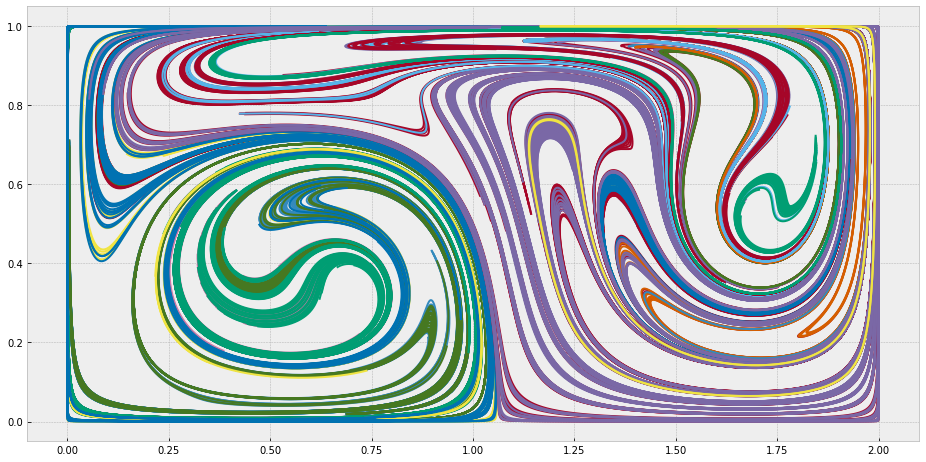

In [334]:
fig = plt.figure(figsize=(16,8))

plotted = set([])
mult = 0.5
   



for i in range(len(fLCSs)):
    if i not in plotted:
        line1 = fLCSs[i]
        I, = plt.plot(line1[0,:], line1[1,:])
        plotted.add(i)
        threshold = mult*np.median(nearest_nbs_inv[i,np.where(nearest_nbs_inv[i,:] > 0 )])
        for j in range(len(fLCSs)):
            if j not in plotted:
                if max(nearest_nbs_inv[i,j], nearest_nbs_inv[j,i]) > threshold:
                    line2 = fLCSs[j]
                    plt.plot(line2[0,:], line2[1,:], c = I.get_color())
                    plotted.add(j)

[  19   20   26   66   73   88  108  269  270  276  277  282  287  399
  400  405  668  670  671  738  739  749  766  770  772  773  774  780
  783  788  798  799 1109 1110 1172 1174 1175 1184 1185 1190 1192 1194
 1202 1203 1205 1206 1207 1208 1209 1213 1214 1216 1219]
2.4349449331670443


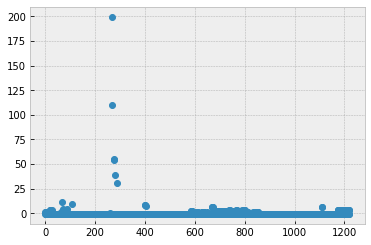

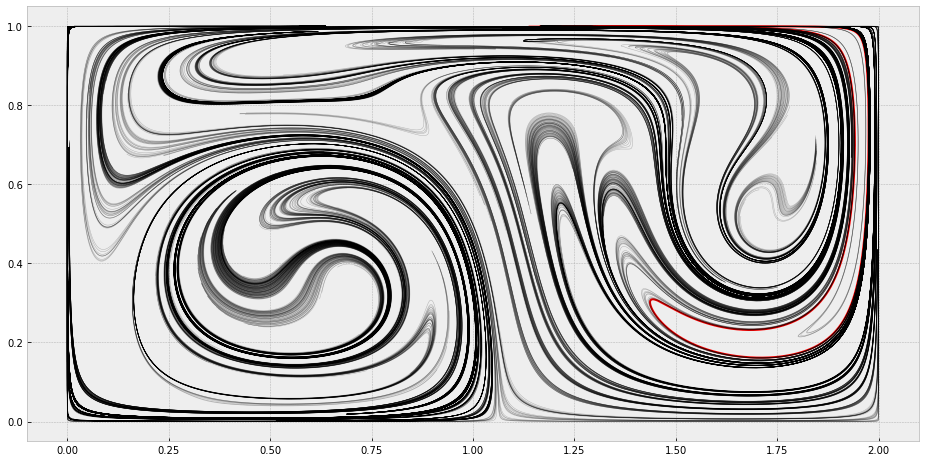

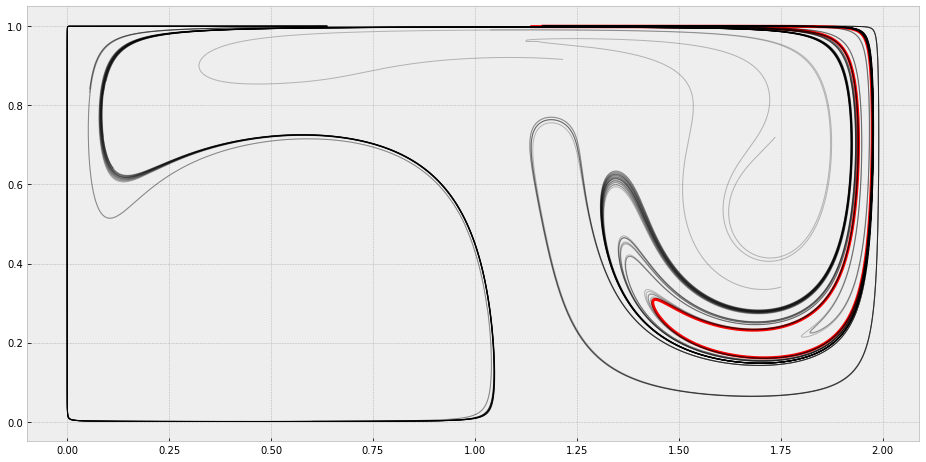

In [335]:
# fig = plt.figure(figsize=(16,8))
num =262
mult = 1
   
threshold = mult*np.median(nearest_nbs_inv[num,np.where(nearest_nbs_inv[num,:] > 0 )])

#%maplotlib notebook


plt.plot(np.linspace(0,nearest_nbs.shape[0], nearest_nbs.shape[0]),nearest_nbs_inv[num,:],'o')
#pick closest lines
friendsof_num = np.where(nearest_nbs_inv[num,:] > threshold )
friendsof_num[0]
fig = plt.figure(figsize=(16,8))
plt.plot(fLCSs[num][0,:], fLCSs[num][1,:], c = 'r', lw = 2)
for i in range(len(fLCSs)):
#     i = friendsof_73[j]
    plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 0.5, alpha=0.25 )
    
# fig = plt.figure(figsize=(16,8))
# plt.plot(fLCSs[num][0,:], fLCSs[num][1,:], c = 'r', lw = 2)
# for i in range(len(fLCSs)):
#     plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 0.5, alpha=0.25 )
# plt.xlim([1.6,1.75])
# plt.ylim([0.8, 1])

#plot to see if it makes sense
fig = plt.figure(figsize=(16,8))
plt.plot(fLCSs[num][0,:], fLCSs[num][1,:], c = 'r', lw = 3 )
for i in set(friendsof_num[0]):
#     i = friendsof_73[j]
    plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 1, alpha=0.25)
    
print(friendsof_num[0])
print(threshold)

In [336]:
# fLCSs = strainlines
minn = len(fLCSs[0][0,:])
maxx = 0
for i in range(len(fLCSs)):
    if(len(fLCSs[i][0,:]) < minn):
        minn = len(fLCSs[i][0,:])
    if(len(fLCSs[i][0,:]) > maxx):
        maxx = len(fLCSs[i][0,:])

print('max length of LCS: %d' % maxx)
print('min length of LCS: %d' % minn)

max length of LCS: 10031
min length of LCS: 3015


In [337]:
from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA
from sklearn.feature_selection import VarianceThreshold
from sklearn import datasets, cluster
from sklearn import preprocessing

from mpl_toolkits.mplot3d import Axes3D
#%matplotlib notebook
%matplotlib inline
size = minn
X = np.zeros((len(fLCSs), size))
y = np.zeros((len(fLCSs), size))
eigs = np.zeros((len(fLCSs), size))
for i in range(len(fLCSs)):
    ratio = 1 - len(fLCSs[i][0,:]) / size
    multiplier = int(len(fLCSs[i][0,:]) / size)
    offset = 0

#     offset = int(len(fLCSs[i][0,:]) * ratio / 2 - 0)

    #print(offset)
    #print(len(fLCSs[i][0,:]))
    for j in range(size):#len(fLCSs[i][0,:])):
        
        X[i, j + offset] = fLCSs[i][0, j * multiplier]
        y[i, j + offset] = fLCSs[i][1, j * multiplier]
        #eigs[i, j + offset] = running_eigvals[i][j * multiplier]


# n_comps = 10
# # sel0 = VarianceThreshold(threshold=0.0)
# # # for i in range(len(X[0,:])):
# # #     print(np.var(X[:,i]))
# # X = sel0.fit_transform(X)
# # y = sel0.fit_transform(y)
# # print(X.shape)
# # print(y.shape)
# ipca = IncrementalPCA(n_components=n_comps, whiten=True)
# X_ipca = ipca.fit_transform(X, y)

# pca = PCA(n_components=n_comps,svd_solver='full', whiten=True)
# X_pca = pca.fit_transform(X, y)


# colors = ['navy', 'turquoise', 'darkorange']
# fig = plt.figure(figsize=(16,8))
# plt.scatter(X_pca[:,0], X_pca[:,1], color = 'k')

# plt.scatter(X_ipca[:,0], X_ipca[:,1])
# plt.show()

# agglo = cluster.FeatureAgglomeration(connectivity=None,
#                                      n_clusters=n_comps)

# agglo.fit(X)
# X_reduced = agglo.transform(X)
# print(X_reduced.shape)
# # plt.scatter(X_reduced[:,0], X_reduced[:, 1])





n_comps = 25
kpca0 = KernelPCA(kernel="rbf", fit_inverse_transform=True, n_components=n_comps)
kpca1 = KernelPCA(kernel="cosine", fit_inverse_transform=True, n_components=n_comps)
kpca2 = KernelPCA(kernel="linear", fit_inverse_transform=True, n_components=n_comps)
kpca3 = KernelPCA(kernel="poly", fit_inverse_transform=True, n_components=n_comps)
# X_kpca0 = kpca0.fit_transform(X, y)
# #X_kpca0 = kpca0.fit_transform(X_kpca0, nearest_nbs_inv)

# X_kpca1 = kpca1.fit_transform(X, y)
# #X_kpca1 = kpca1.fit_transform(X_kpca1, nearest_nbs_inv)

X_kpca2 = kpca2.fit_transform(X, y)
X_kpca2 = kpca2.fit_transform(X_kpca2, nearest_nbs_inv)

# X_kpca3 = kpca3.fit_transform(X, y)
#X_kpca3 = kpca3.fit_transform(X_kpca3, nearest_nbs_inv)
NEIGH_feats = kpca0.fit_transform(nearest_nbs)
print('done')


done


(1220, 25)


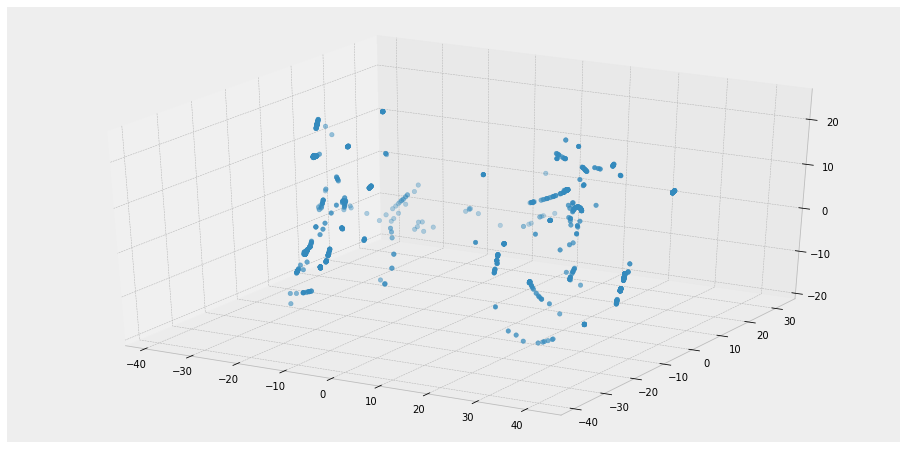

(1220, 25)


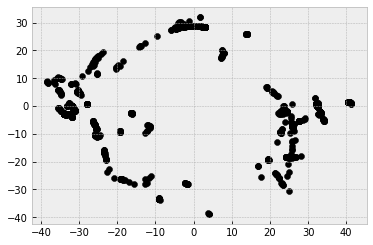

In [338]:
X_new = X_kpca2[:,0::]
#X_kpca = kpca1.fit_transform(X_kpca, nearest_nbs)
print(X_new.shape)
# #fig = plt.figure(figsize=(16,8))
# plt.scatter(X_kpca[:,0], X_kpca[:,1])
fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(111, projection='3d')


ax.scatter(xs=X_new[:,0], ys=X_new[:,1], zs=X_new[:,2], zdir='z')
plt.show()

X_new = X_new#[:, ::1]
# fig = plt.figure(figsize=(16,8))
plt.scatter(X_new[:,0], X_new[:,1], color = 'k')
print(X_new.shape)

In [339]:
def find_max_lcss(fLCSs, n_clusters_, labels, flen, flambs):
    num_clust = n_clusters_

    #flengths
    #eigvals_mean

    #array for holding the selected LCSs
    chosen_LCS = []
    #find which lines belong to a cluster
    
    
    ####need to fix here for second run -- cant multiply by step and expect correct indices. mapping?
    len_min = 1.0
    for k in range(num_clust):
        #print("cluster %d  " %k)
        my_members = labels == k
        if(my_members.size == 1): continue
        indices = np.where(my_members)
        #print((indices))
        local_lines = []
        if (len(indices[0]) < 3 or indices[0] is None):
            continue
        for i in range(len(indices)):

            local_lines.append(indices[0][i])
    
        #local_lines = indices
        
        
        ind = 0
        identity = -1
        maxi_lamb = 0
        maxi_len = 0
        leng = len(local_lines)
        #print(local_lines)
        for i in set(local_lines):
            if flengths[i] > len_min:
                if eigvals_mean[i] > maxi_lamb:
                #if flengths[i] > flengths[identity]:# and (np.abs(eigvals_mean[i] - maxi_lamb) < 1e-1 or eigvals_mean[i] > maxi_lamb):
                    identity = i
                    maxi_lamb = eigvals_mean[i]
                    maxi_len = flengths[i] 
                else:
                    if eigvals_mean[i] == maxi_lamb and flengths[i] > maxi_len:
                        identity = i
                        maxi_len = flengths[i]
                        maxi_lamb = eigvals_mean[i]
        if identity not in chosen_LCS and identity != -1: chosen_LCS.append(identity)
        #print("identity: %d \n" % identity)

    print(chosen_LCS)

    return chosen_LCS

Number of samples which gave wanted number of clusters 13
Setting up took 0.285 seconds
number of estimated clusters : 21
[0, 2, 1, 44, 65, 66, 89, 122, 16, 322, 428, 463, 597, 862, 868, 995, 998, 1087, 1130, 1172, 1173]


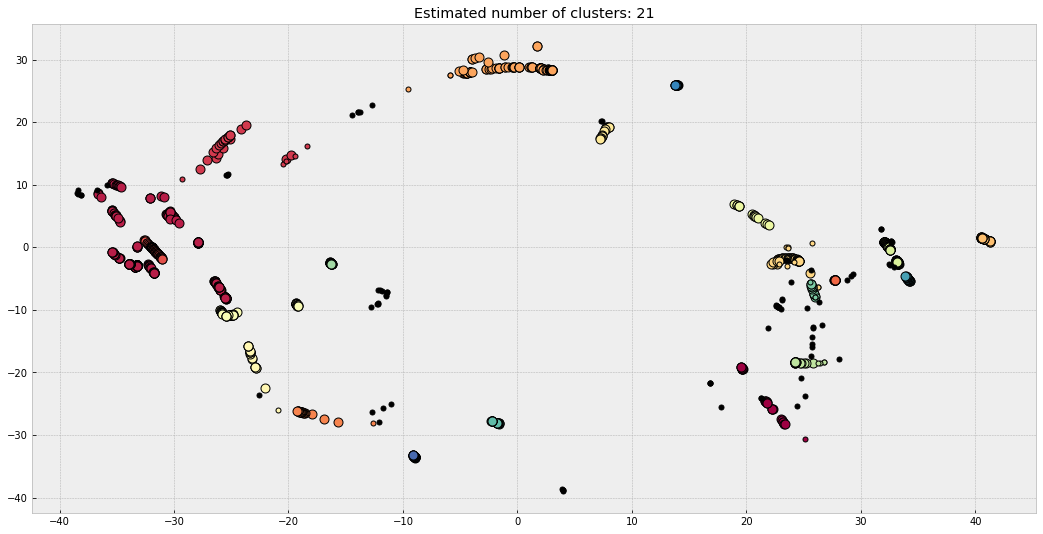

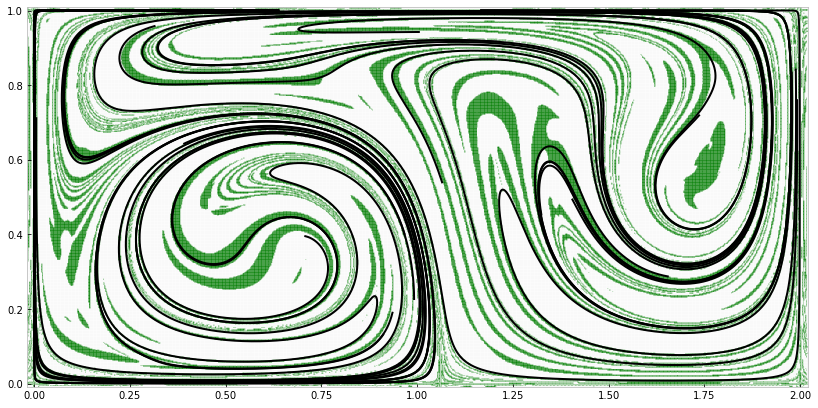

In [374]:
##### from itertools import cycle
X_ = X_new

# n_clusters_, labels, cluster_centers = ms_clust(X_, 12, 0.1, seed=seeds)


n_clusters_, labels, core_samples_mask = db_scan_it(X_, 20, 25, 9)

    
import time as tid
fig = plt.figure(figsize=(18,9))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=9)

    xy = X_[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=5)
    #plt.show()
    #tid.sleep(0.5)
plt.title('Estimated number of clusters: %d' % n_clusters_)

chosen_LCS = find_max_lcss(fLCSs, n_clusters_, labels, flengths, eigvals_mean)
maks = np.amax(flengths)
fig = plt.figure(figsize=(14,7))
plt.pcolormesh(X0[0,:,:], X0[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.25)
for i in set(chosen_LCS):
    if(flengths[i] > maks*0.20): plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2 )
# plt.savefig('Kpca_DB_' + fig_num +'.png')

In [375]:
def cherryPicker(chosen_LCS, flambs, nearest_nbs_inv, epsilon, mult=0.5):
    count = len(chosen_LCS)
    num_lines = len(nearest_nbs_inv[0,:])
    new_chosen = []
    for i in set(chosen_LCS):
        threshold = mult*np.median(nearest_nbs_inv[i,np.where(nearest_nbs_inv[i,:] > 0 )])
        similars = []
        similars.append(i)
        for j in set(chosen_LCS):
            if i == j: continue
            if max(nearest_nbs_inv[i,j], nearest_nbs_inv[j,i]) > threshold:
                similars.append(j)
        line = i
        for k in range(len(similars)):
            if flambs[i] < flambs[similars[k]]:
                line = similars[k]
        #try to weed out the weak
        for o in set(similars):
            if o in new_chosen:# and np.abs(flengths[o] - flengths[line]) > 0.7*max(flengths[o], flengths[line]):
                new_chosen.remove(o)
#                 print('removing')
        
        if line not in new_chosen:
            new_chosen.append(line)
    return new_chosen

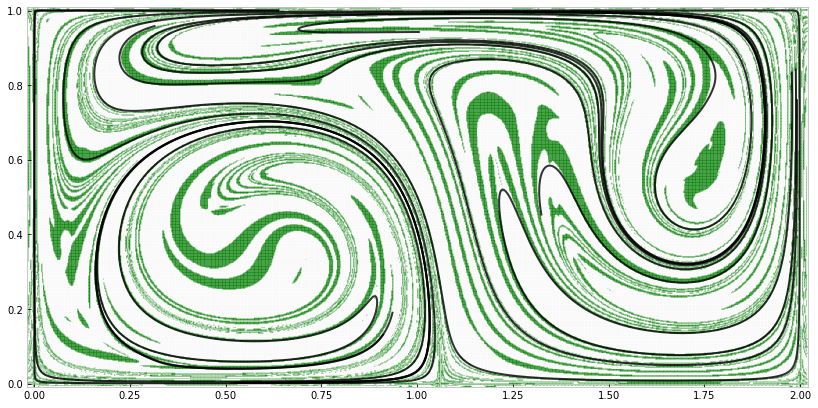

In [376]:

new_chosen = cherryPicker(chosen_LCS, eigvals_mean, nearest_nbs_inv, epsilon, mult=1)
# new_chosen = cherryPicker(chosen_LCS, eigvals_mean, nearest_nbs_inv, epsilon, mult=1)
maks = np.amax(flengths)
fig = plt.figure(figsize=(14,7))
plt.pcolormesh(X0[0,:,:], X0[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.25)
for i in set(new_chosen):
    if(flengths[i] > maks*0.2): plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2, alpha=0.8 )
plt.savefig('Kpca_DB_' + fig_num +'.png')

# print(chosen_LCS)
# print(new_chosen)

In [343]:
def plot_clustering(X_red, X, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    plt.figure(figsize=(14, 7))
    for i in range(X_red.shape[0]):
        plt.scatter(X_red[i, 0], X_red[i, 1],
                 color=plt.cm.spectral(labels[i] / 10.))
    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('off')
    plt.tight_layout()

/home/and/anaconda3/lib/python3.6/site-packages/sklearn/cluster/hierarchical.py:426: UserWarning: the number of connected components of the connectivity matrix is 6 > 1. Completing it to avoid stopping the tree early.
  affinity=affinity)


[28, 0, 1, 1013, 44, 998, 2, 1162, 666, 886, 995, 1173, 322, 861, 1172, 1132, 1087, 440]
10.029320683174356


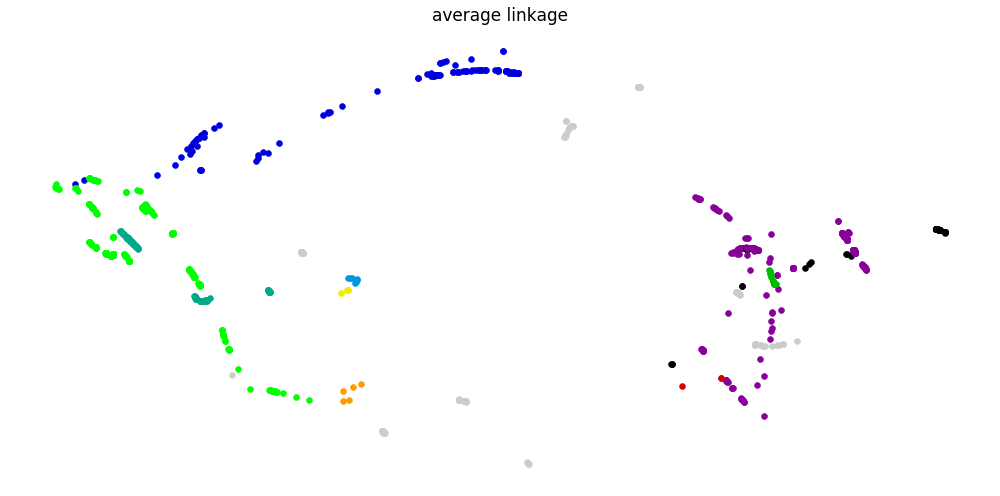

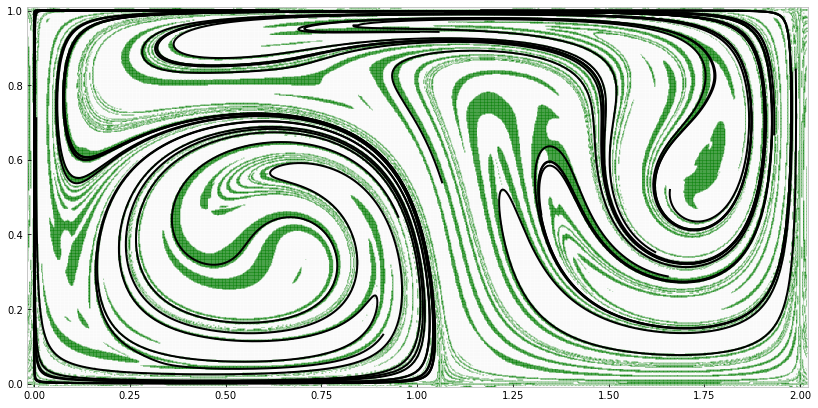

In [344]:
from sklearn.cluster import AgglomerativeClustering
from sklearn import manifold, datasets
from sklearn.neighbors import kneighbors_graph, radius_neighbors_graph

knn_graph = kneighbors_graph(X_, 20, include_self=False, mode='connectivity', p = 2)
#knn_graph = radius_neighbors_graph(X_, 0.2, include_self=False, mode='connectivity', p = 2)
# fLCSs = strainlines


X_red = X_
linkage = 'average'
n_clusters_=20
clustering = AgglomerativeClustering(
    linkage=linkage,connectivity = knn_graph,
    n_clusters=n_clusters_, affinity='euclidean')

clustering.fit(X_red)

plot_clustering(X_red, X_, clustering.labels_, "%s linkage" % linkage)
labels = clustering.labels_
chosen_LCS = find_max_lcss(fLCSs, n_clusters_, labels, flengths, eigvals_mean)

fig = plt.figure(figsize=(14,7))
plt.pcolormesh(X0[0,:,:], X0[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.25)
maks = np.amax(flengths)
print(maks)
for i in set(chosen_LCS):
    if(flengths[i] > maks*0.20): 
        plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2 )#eigvals_mean[i]/(10*np.max(eigval_mean)))
#         print(i)

# plt.savefig('kpca_agg_' + fig_num +'.png')

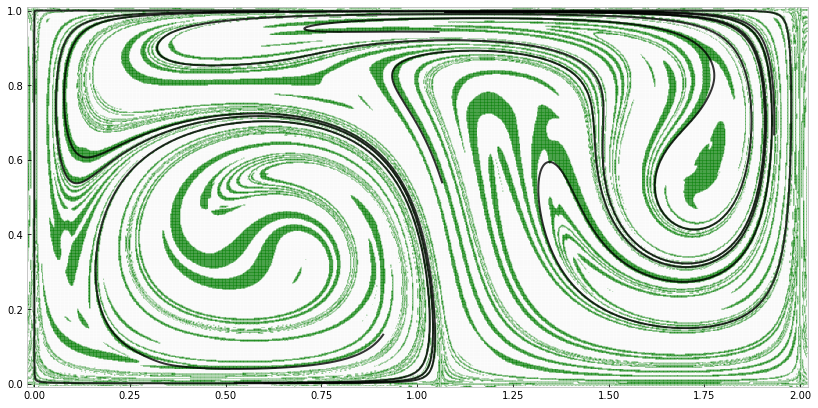

In [345]:
new_chosen = cherryPicker(chosen_LCS, eigvals_mean, nearest_nbs_inv, epsilon)
maks = np.amax(flengths)
fig = plt.figure(figsize=(14,7))
plt.pcolormesh(X0[0,:,:], X0[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.25)
for i in set(new_chosen):
    if(flengths[i] > maks*0.2): plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2, alpha=0.8 )
plt.savefig('kpca_agg_' + fig_num +'.png')

[79, 1, 440, 89, 796, 2, 463, 16, 0, 247, 1172, 19, 1173, 477, 44, 995, 66, 322, 1130, 36]
10.029320683174356


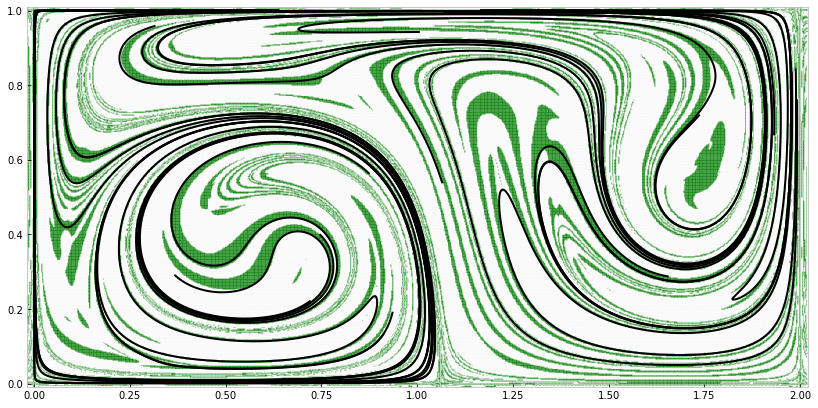

In [346]:
from sklearn.cluster import KMeans
n_clusters_ = 20
random_state = 0
y_pred = KMeans(n_clusters=n_clusters_, random_state=random_state, init='k-means++')
y_pred.fit_predict(X_)

labels = y_pred.labels_

chosen_LCS = find_max_lcss(fLCSs, n_clusters_, labels, flengths, eigvals_mean)

fig = plt.figure(figsize=(14,7))
plt.pcolormesh(X0[0,:,:], X0[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.25)
maks = np.amax(flengths)
print(maks)
for i in set(chosen_LCS):
    if(flengths[i] > maks*0.2): plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2 )
# plt.savefig('kpca_kmean_' + fig_num +'.png')


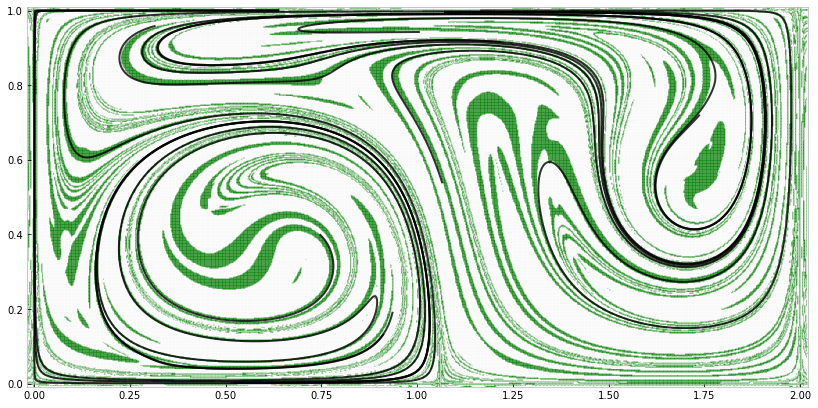

In [347]:
new_chosen = cherryPicker(chosen_LCS, eigvals_mean, nearest_nbs_inv, epsilon)
maks = np.amax(flengths)
fig = plt.figure(figsize=(14,7))
plt.pcolormesh(X0[0,:,:], X0[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.25)
for i in set(new_chosen):
    if(flengths[i] > maks*0.2): plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2, alpha=0.8 )
plt.savefig('kpca_kmean_' + fig_num +'.png')

Estimated number of clusters: 27
[2, 1, 52, 79, 125, 261, 146, 36, 322, 44, 0, 19, 463, 428, 16, 6, 66, 477, 998, 440, 796, 1013, 995, 1130, 1132, 1173, 1172]
10.029320683174356


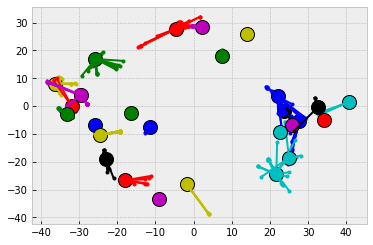

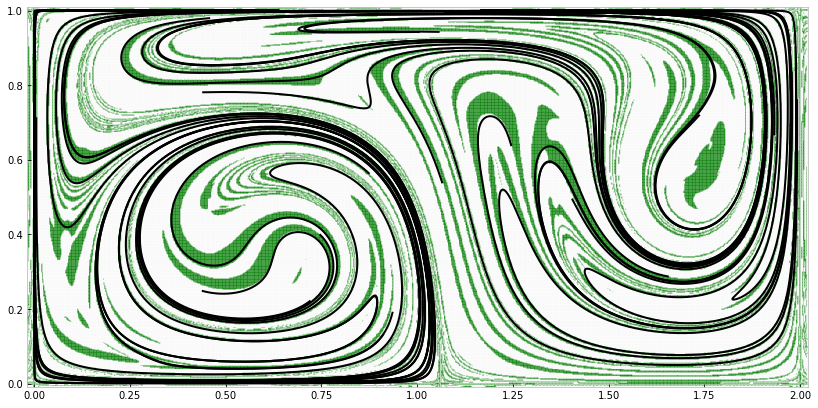

In [348]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from itertools import cycle
af = AffinityPropagation(damping=.9).fit(X_)
# print(nearest_nbs[::3,::3])
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_


n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X_[cluster_centers_indices[k]]
    plt.plot(X_[class_members, 0], X_[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X_[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)
        
chosen_LCS = find_max_lcss(fLCSs, n_clusters_, labels, flengths, eigvals_mean)

fig = plt.figure(figsize=(14,7))
plt.pcolormesh(X0[0,:,:], X0[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.25)
maks = np.amax(flengths)
print(maks)
for i in set(chosen_LCS):
    if(flengths[i] > maks*0.2): plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2 )#eigvals_mean[i]/(10*np.max(eigval_mean)))

# plt.savefig('kpca_affi_' + fig_num +'.png')

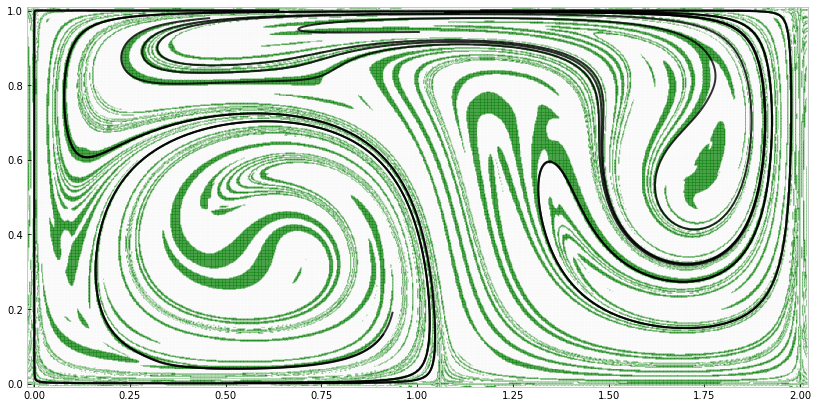

In [349]:
new_chosen = cherryPicker(chosen_LCS, eigvals_mean, nearest_nbs_inv, epsilon)


for i in range(1): new_chosen = cherryPicker(new_chosen, eigvals_mean, nearest_nbs_inv, epsilon)
maks = np.amax(flengths)
fig = plt.figure(figsize=(14,7))
plt.pcolormesh(X0[0,:,:], X0[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.25)
for i in set(new_chosen):
    if(flengths[i] > maks*0.20): plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2, alpha=0.8 )
plt.savefig('kpca_affi_' + fig_num +'.png')

[2, 862, 89, 44, 79, 146, 66, 1, 322, 16, 0, 1173, 36, 868, 1087, 1172, 995, 998, 1132, 1013, 73, 440, 1162, 28, 886]
10.029320683174356


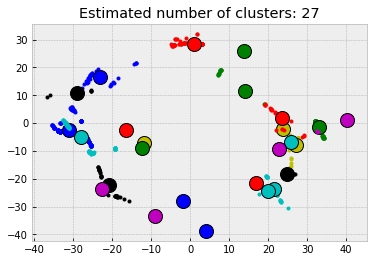

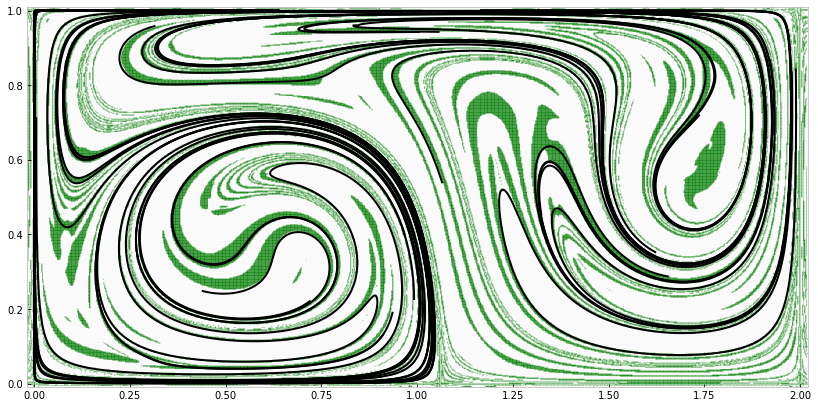

In [350]:
from sklearn.cluster import MeanShift, estimate_bandwidth

bandwidth = estimate_bandwidth(X_, quantile=0.08)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all = False)
ms.fit(X_)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_ - 1), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X_[my_members, 0], X_[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)

chosen_LCS = find_max_lcss(fLCSs, n_clusters_, labels, flengths, eigvals_mean)

fig = plt.figure(figsize=(14,7))
plt.pcolormesh(X0[0,:,:], X0[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.25)
maks = np.amax(flengths)
print(maks)
for i in set(chosen_LCS):
    if(flengths[i] > maks*0.20): plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2 )#eigvals_mean[i]/(10*np.max(eigval_mean)))


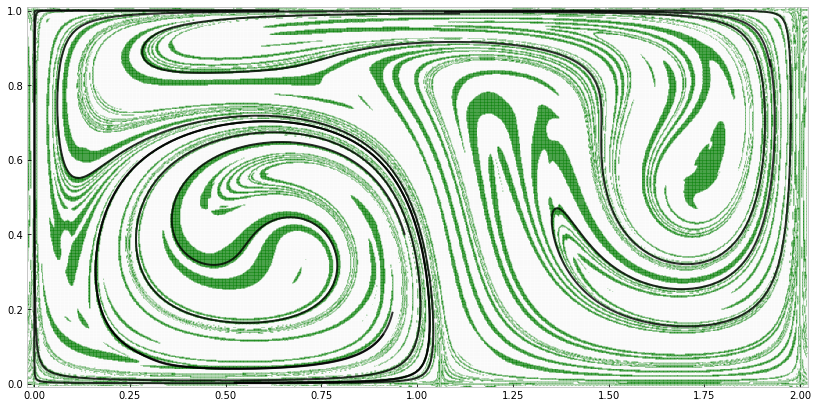

In [351]:
new_chosen = cherryPicker(chosen_LCS, eigvals_mean, nearest_nbs_inv, epsilon)
#new_chosen = cherryPicker(new_chosen, eigvals_mean, nearest_nbs_inv, epsilon)
maks = np.amax(flengths)
fig = plt.figure(figsize=(14,7))
plt.pcolormesh(X0[0,:,:], X0[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.25)
for i in set(new_chosen):
    if(flengths[i] > maks*0.2): plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2, alpha=0.8 )
plt.savefig('kpca_ms_' + fig_num +'.png')

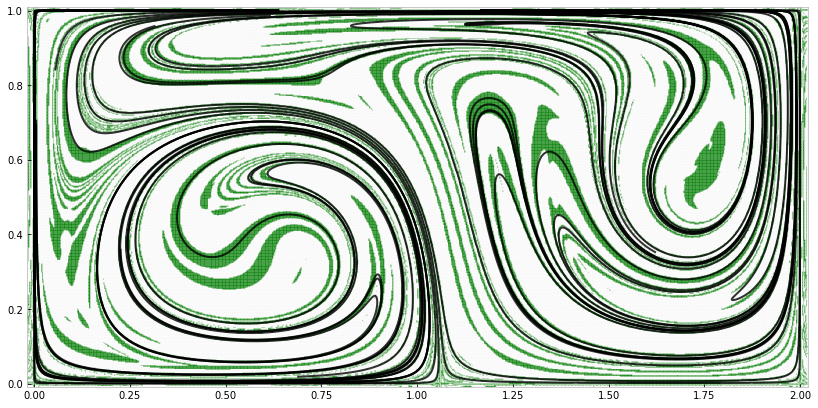

In [352]:
chosen_LCS = [x for x in range(len(fLCSs))]

new_chosen = cherryPicker(chosen_LCS, eigvals_mean, nearest_nbs_inv, epsilon, mult = 10)
new_chosen = cherryPicker(new_chosen, eigvals_mean, nearest_nbs_inv, epsilon, mult = 5)
new_chosen = cherryPicker(new_chosen, eigvals_mean, nearest_nbs_inv, epsilon, mult = 2)
new_chosen = cherryPicker(new_chosen, eigvals_mean, nearest_nbs_inv, epsilon, mult = 1.1)
maks = np.amax(flengths)
fig = plt.figure(figsize=(14,7))
plt.pcolormesh(X0[0,:,:], X0[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.25)
for i in set(new_chosen):
    if(flengths[i] > maks*0.2): plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2, alpha=0.8 )
plt.savefig('no_cluster_' + fig_num + '.png')